<a href="https://colab.research.google.com/github/TrzeciakPiotr2300/Uczenie_Maszynowe_2025/blob/main/HW_lab12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---------------------------------------
#First - setup the environment
---------------------------------------

Poniższą linijkę należy uruchomić, po czym wejść w Środowisko wykonawcze -> Uruchom ponownie sesję. Wtedy należy wykonać resztę kodu **pomijając linijkę** "!pip install ....".

The following line should be executed first, then go to Runtime → Restart session. After that, run the rest of the code excluding the line with !pip install ....

In [2]:
!pip install --upgrade --quiet gensim==4.3.0 scikit-learn==1.4.1.post1 numpy==1.24.4 matplotlib==3.7.1

In [4]:
# Krok 1: Import wymaganych bibliotek
import gensim.downloader as api
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm


In [5]:
# Load pre-trained GloVe embeddings (100-dimensional)
embedding_model = api.load("glove-wiki-gigaword-100")

# Helper function to fetch vector
def get_vector(word):
    return embedding_model[word] if word in embedding_model else None

# Helper function to fetch multiple vectors
def get_vectors(words):
    return np.array([get_vector(word) for word in words if get_vector(word) is not None])

[==================================================] 100.0% 128.1/128.1MB downloaded


-----------------------------
#Now, let's define 10 classes
-----------------------------

In [6]:
# Define 10 semantic classes, each with 5 word pairs
semantic_classes = {
    "gender": [
        ("king", "queen"),
        ("man", "woman"),
        ("boy", "girl"),
        ("husband", "wife"),
        ("actor", "actress")
    ],
    "past_tense": [
        ("run", "ran"),
        ("go", "went"),
        ("write", "wrote"),
        ("eat", "ate"),
        ("speak", "spoke")
    ],
    "plural": [
        ("dog", "dogs"),
        ("car", "cars"),
        ("child", "children"),
        ("mouse", "mice"),
        ("foot", "feet")
    ],
    "comparative": [
        ("fast", "faster"),
        ("small", "smaller"),
        ("happy", "happier"),
        ("strong", "stronger"),
        ("bright", "brighter")
    ],
    "superlative": [
        ("fast", "fastest"),
        ("small", "smallest"),
        ("happy", "happiest"),
        ("strong", "strongest"),
        ("bright", "brightest")
    ],
    "country_capital": [
        ("france", "paris"),
        ("italy", "rome"),
        ("germany", "berlin"),
        ("japan", "tokyo"),
        ("egypt", "cairo")
    ],
    "currency": [
        ("usa", "dollar"),
        ("japan", "yen"),
        ("uk", "pound"),
        ("france", "euro"),
        ("china", "yuan")
    ],
    "tool_user": [
        ("pen", "writer"),
        ("hammer", "carpenter"),
        ("brush", "painter"),
        ("scalpel", "surgeon"),
        ("camera", "photographer")
    ],
    "job_object": [
        ("chef", "pan"),
        ("driver", "car"),
        ("farmer", "tractor"),
        ("pianist", "piano"),
        ("teacher", "book")
    ],
    "animal_sound": [
        ("dog", "bark"),
        ("cat", "meow"),
        ("cow", "moo"),
        ("duck", "quack"),
        ("lion", "roar")
    ]
}


In [7]:
### Now we gather all unique words and their vectors:
# Flatten to get all unique words
all_words = set()
for pairs in semantic_classes.values():
    for w1, w2 in pairs:
        all_words.add(w1)
        all_words.add(w2)

# Get vectors only for words present in embedding model
word_vectors = {word: get_vector(word) for word in all_words if get_vector(word) is not None}

# Final word list (with embeddings)
words_with_vectors = list(word_vectors.keys())
print(f"Total unique words with embeddings: {len(words_with_vectors)}")


Total unique words with embeddings: 91


-------------------------------
#Let's jump into plotting (the **PCA**)
-------------------------------

In [8]:
def plot_words_2d(word_list, vectors, title):
    pca = PCA(n_components=2)
    X = np.array([vectors[word] for word in word_list])
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(16, 12))
    #plt.xlim(-4.1, 7.0)
    #plt.ylim(-3.5, 3.5)
    for i, word in enumerate(word_list):
        plt.scatter(X_pca[i, 0], X_pca[i, 1])
        plt.text(X_pca[i, 0] + 0.02, X_pca[i, 1] + 0.02, word, fontsize=9)
    plt.title(title)
    plt.grid(True)
    plt.show()


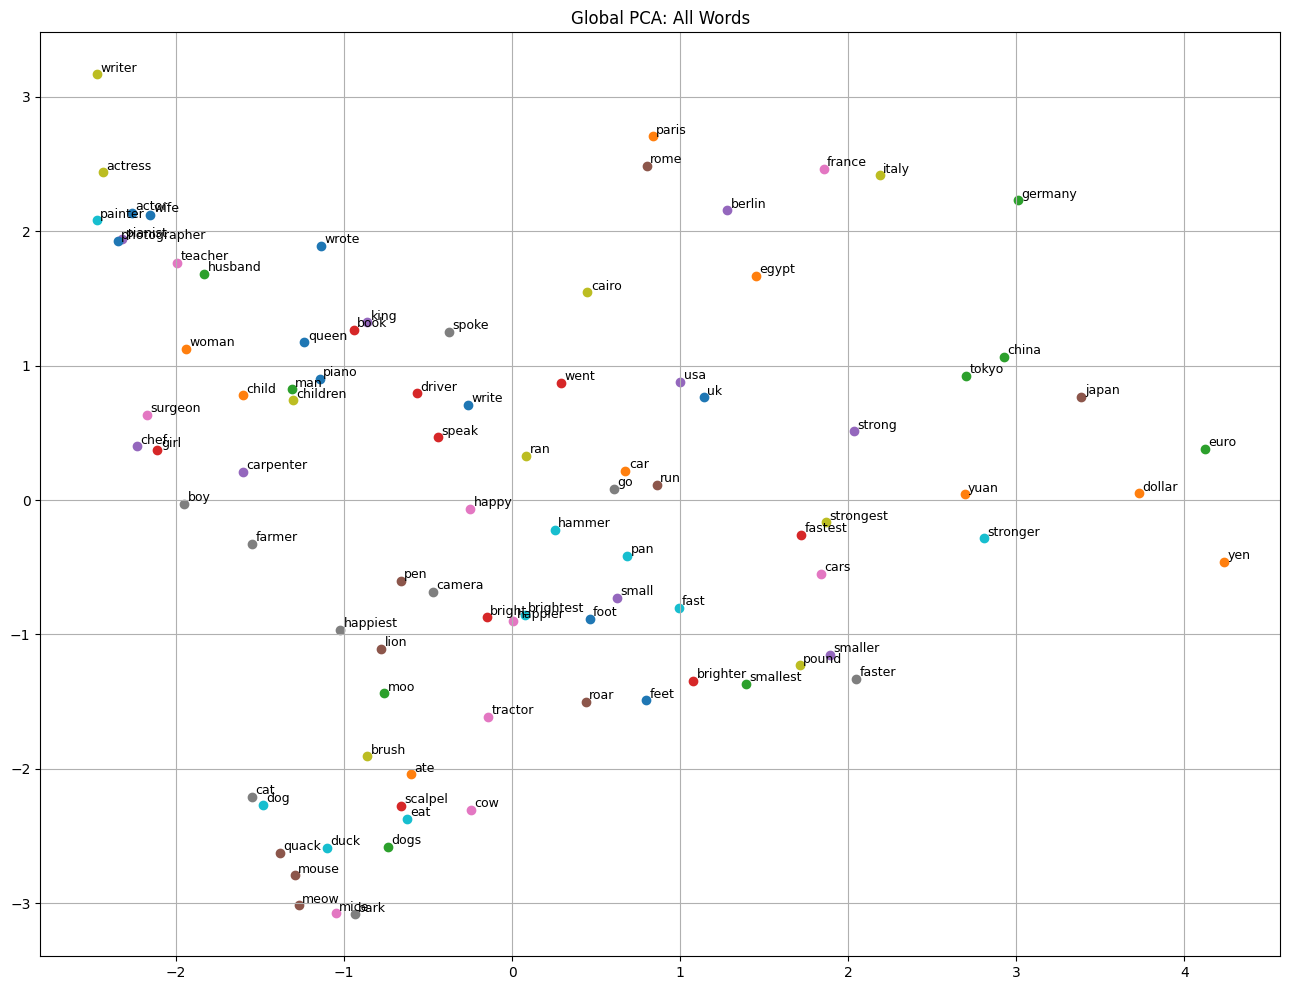

In [9]:
#Global PCA
plot_words_2d(words_with_vectors, word_vectors, "Global PCA: All Words")

**Comment:**
Global PCA help us catch the relationships between classes. Some of them seem to be better separated (like in clustering), for example currencies, animals, capitals. But not every of them is this good separated, like gender (although it's not that far away from each other). This may lead us to think that PCA has a great potential in capturing these semantic meanings. Let's plot more examples...

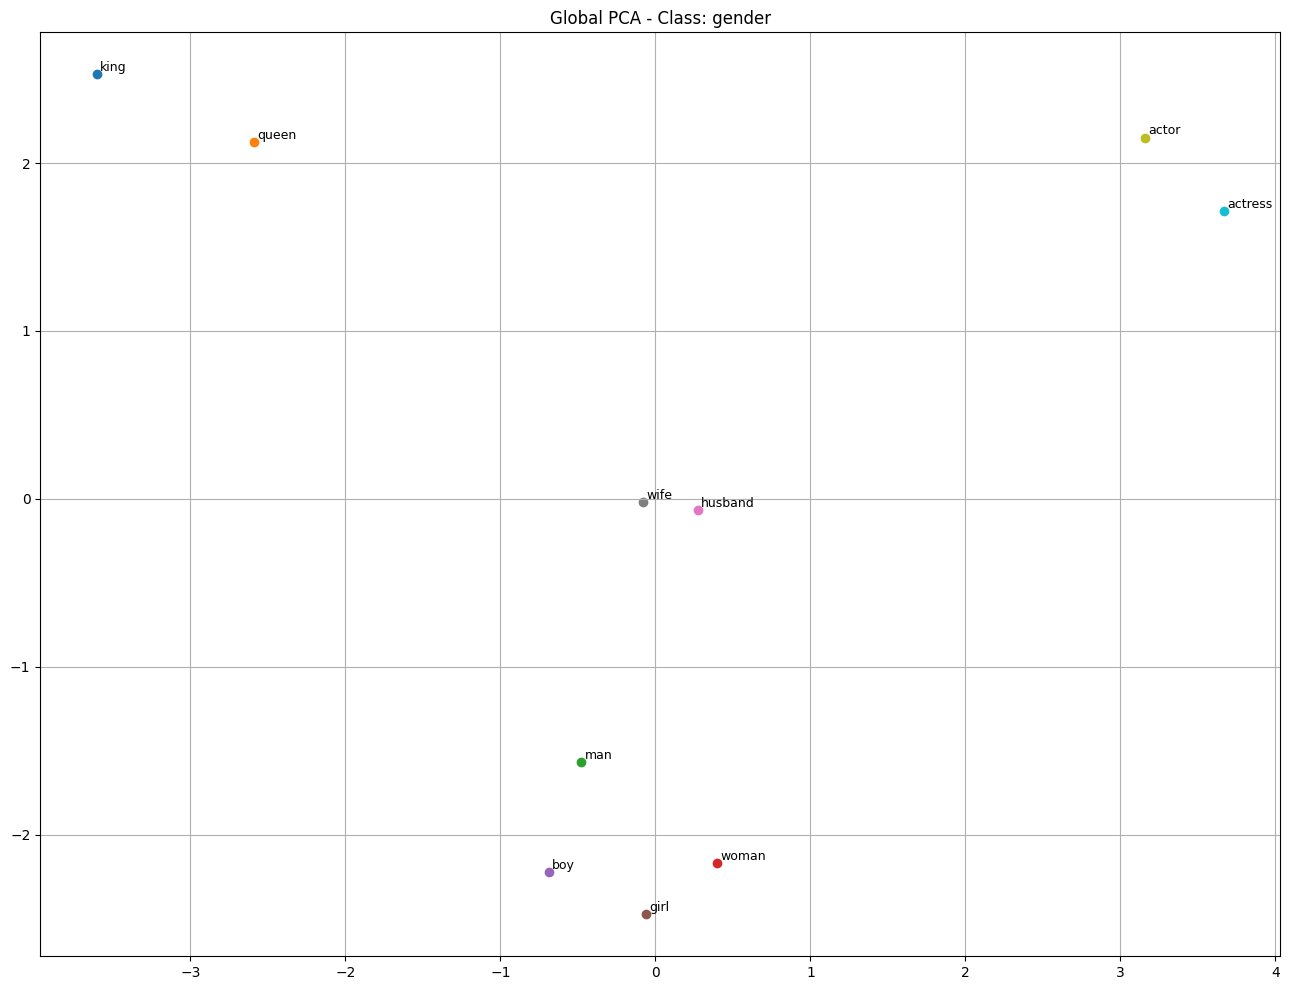

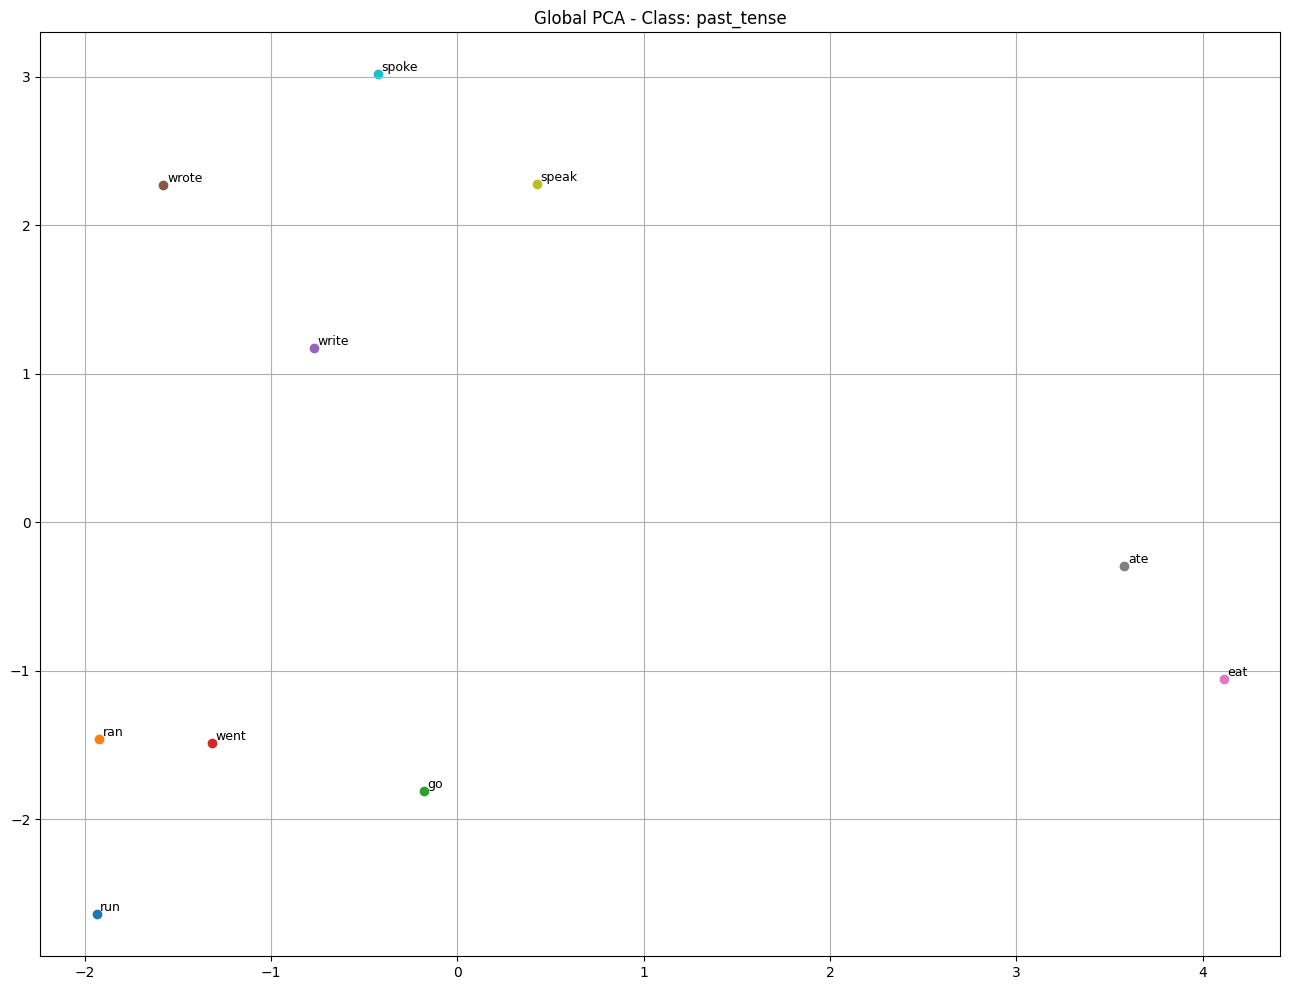

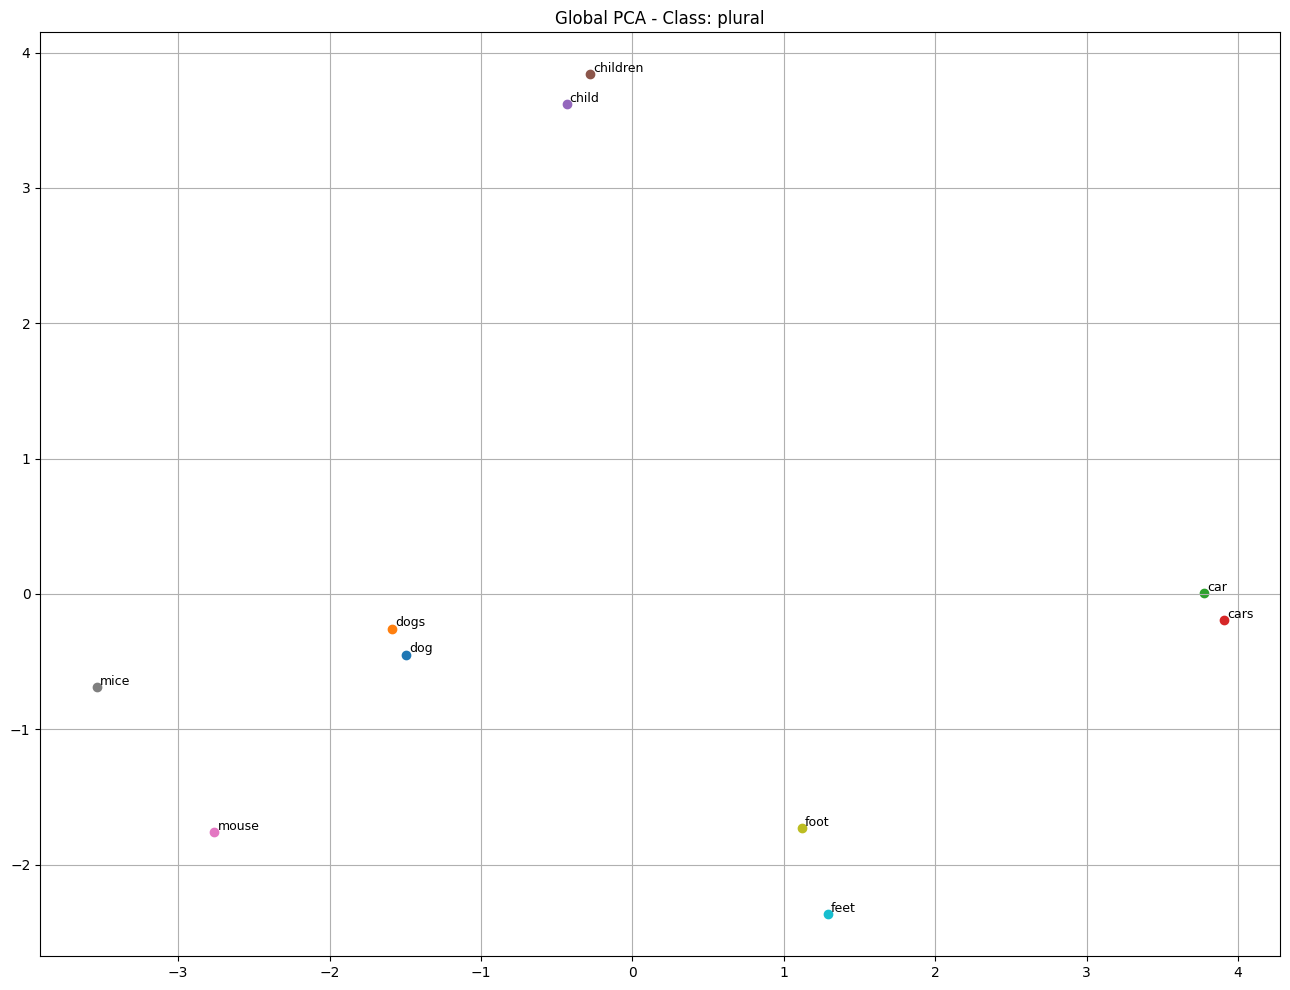

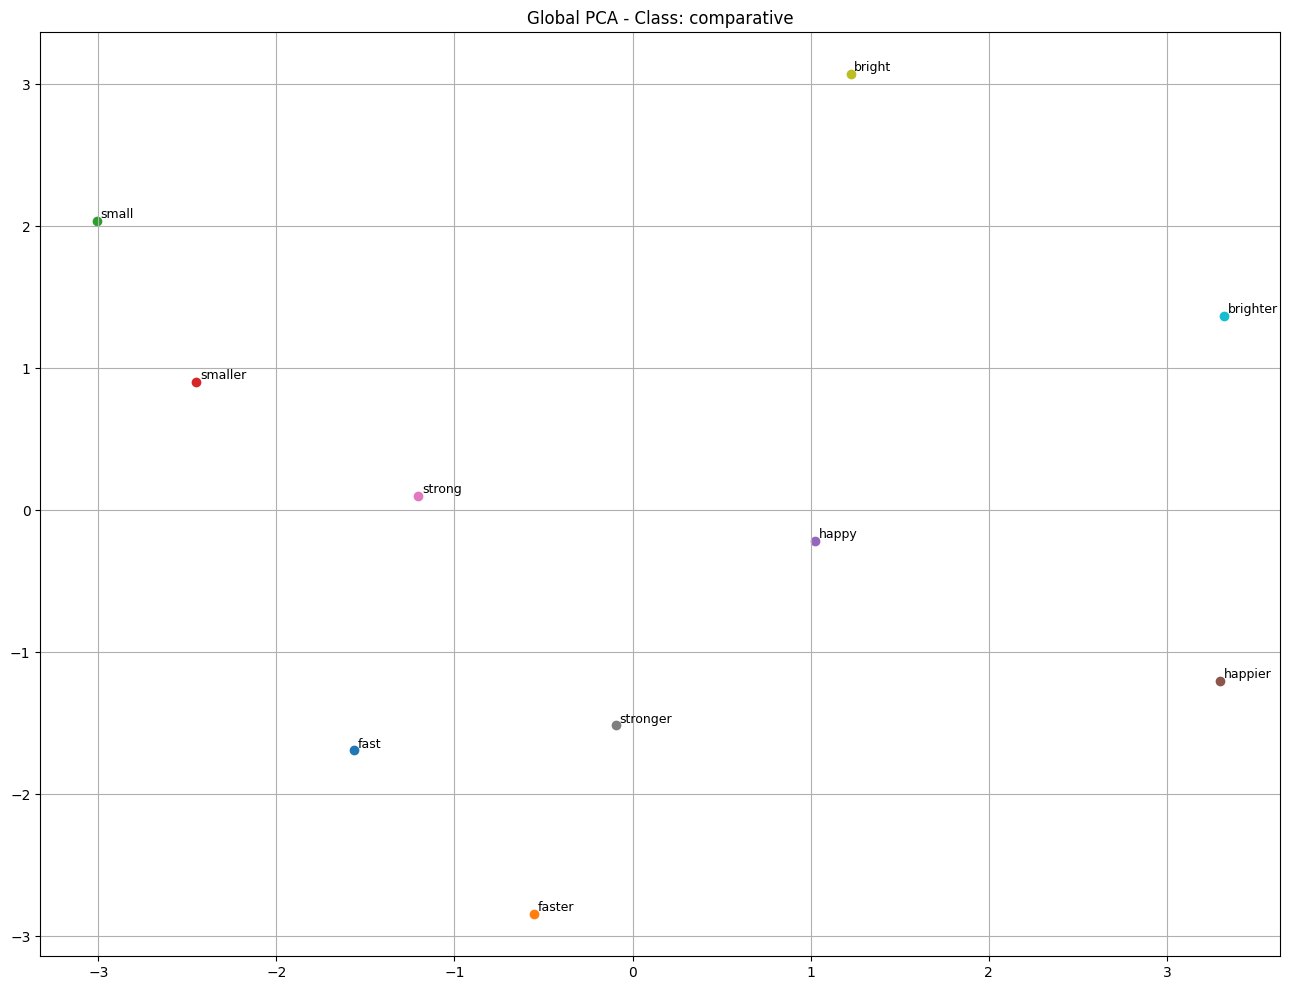

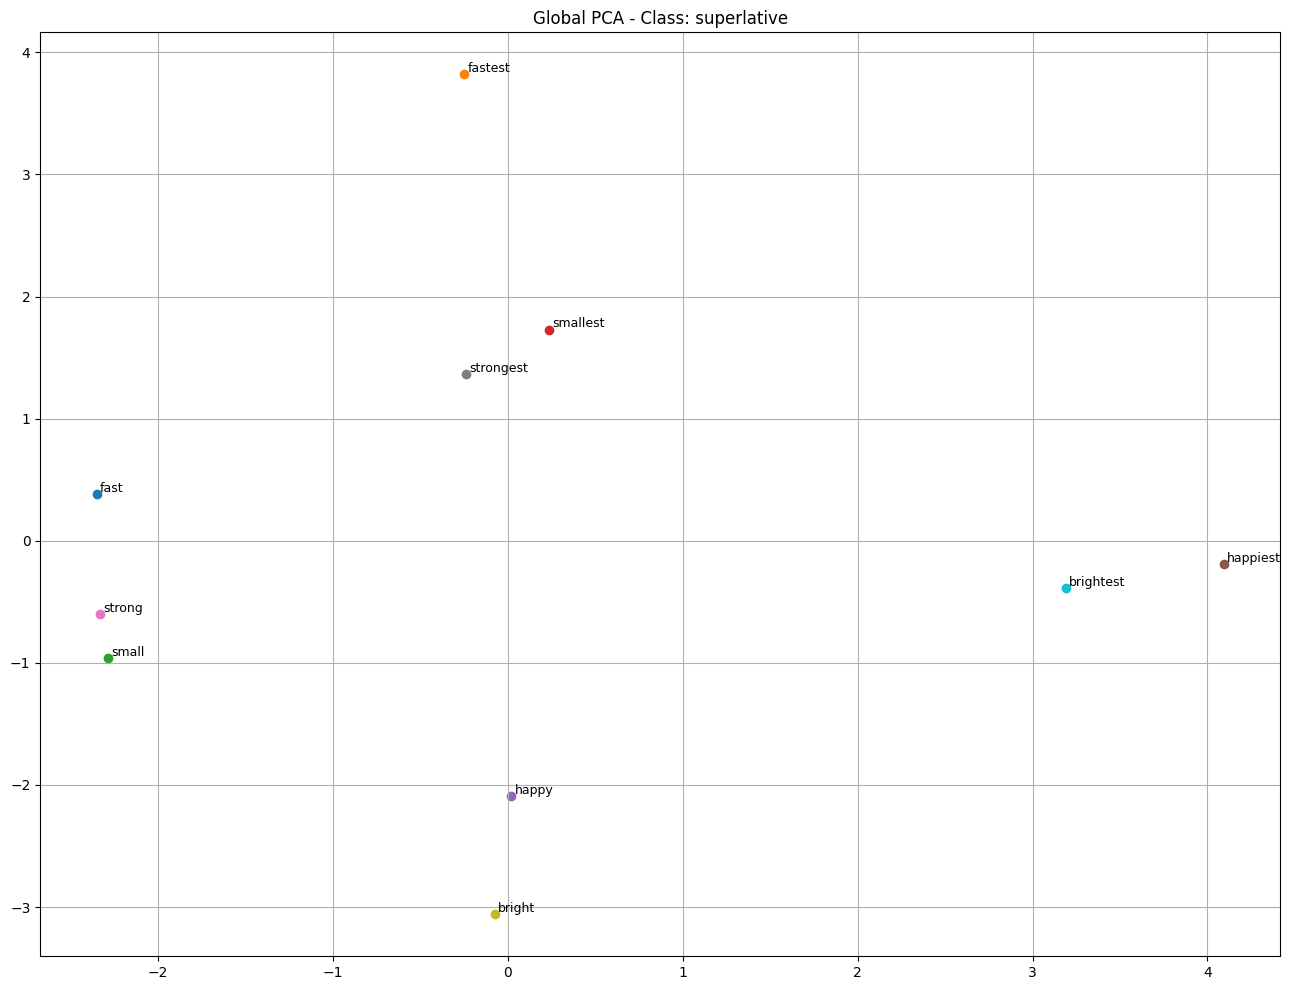

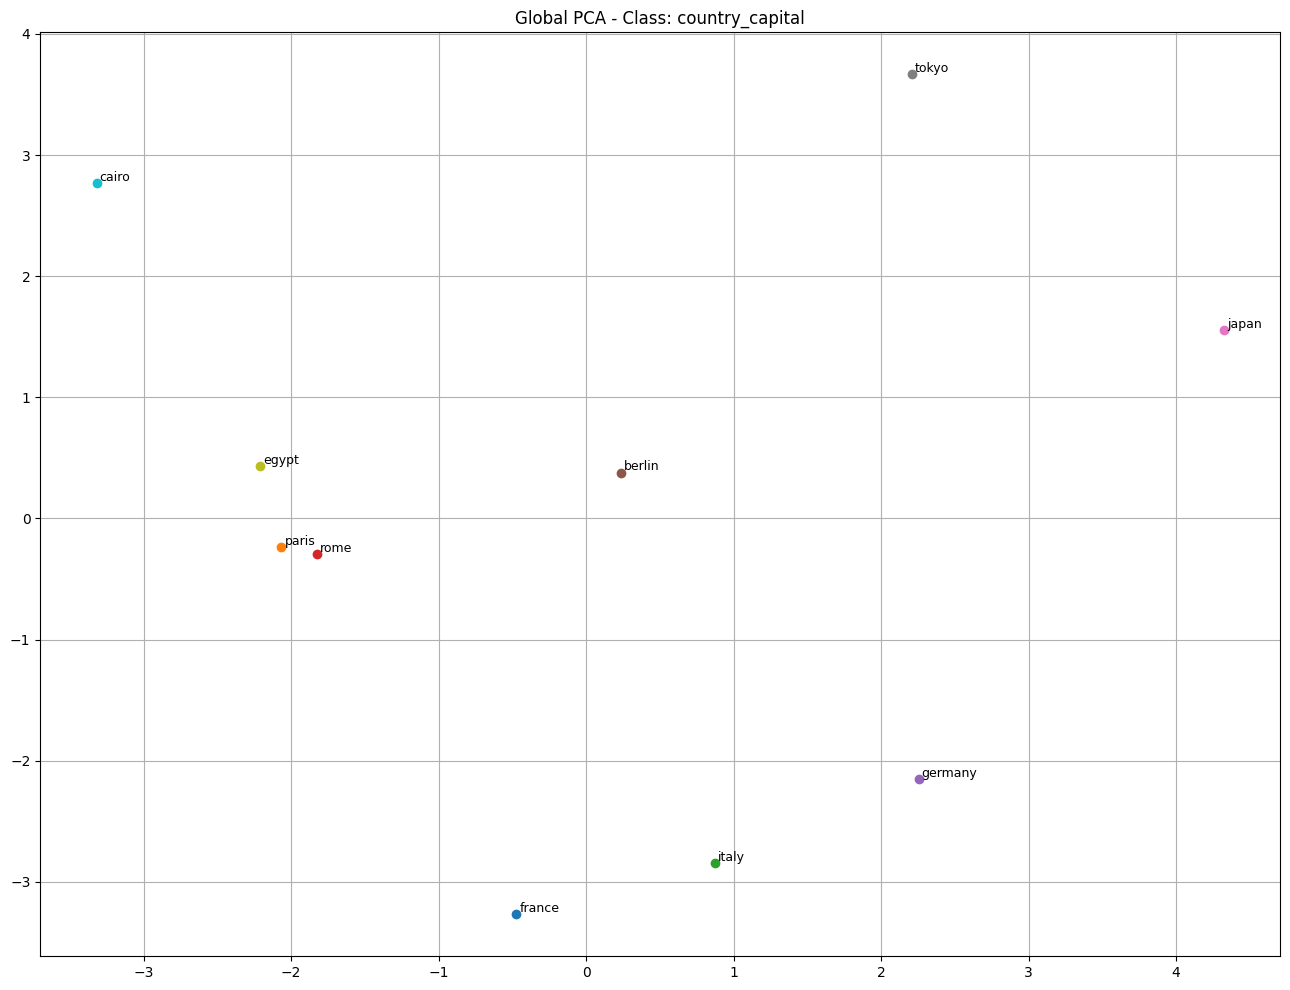

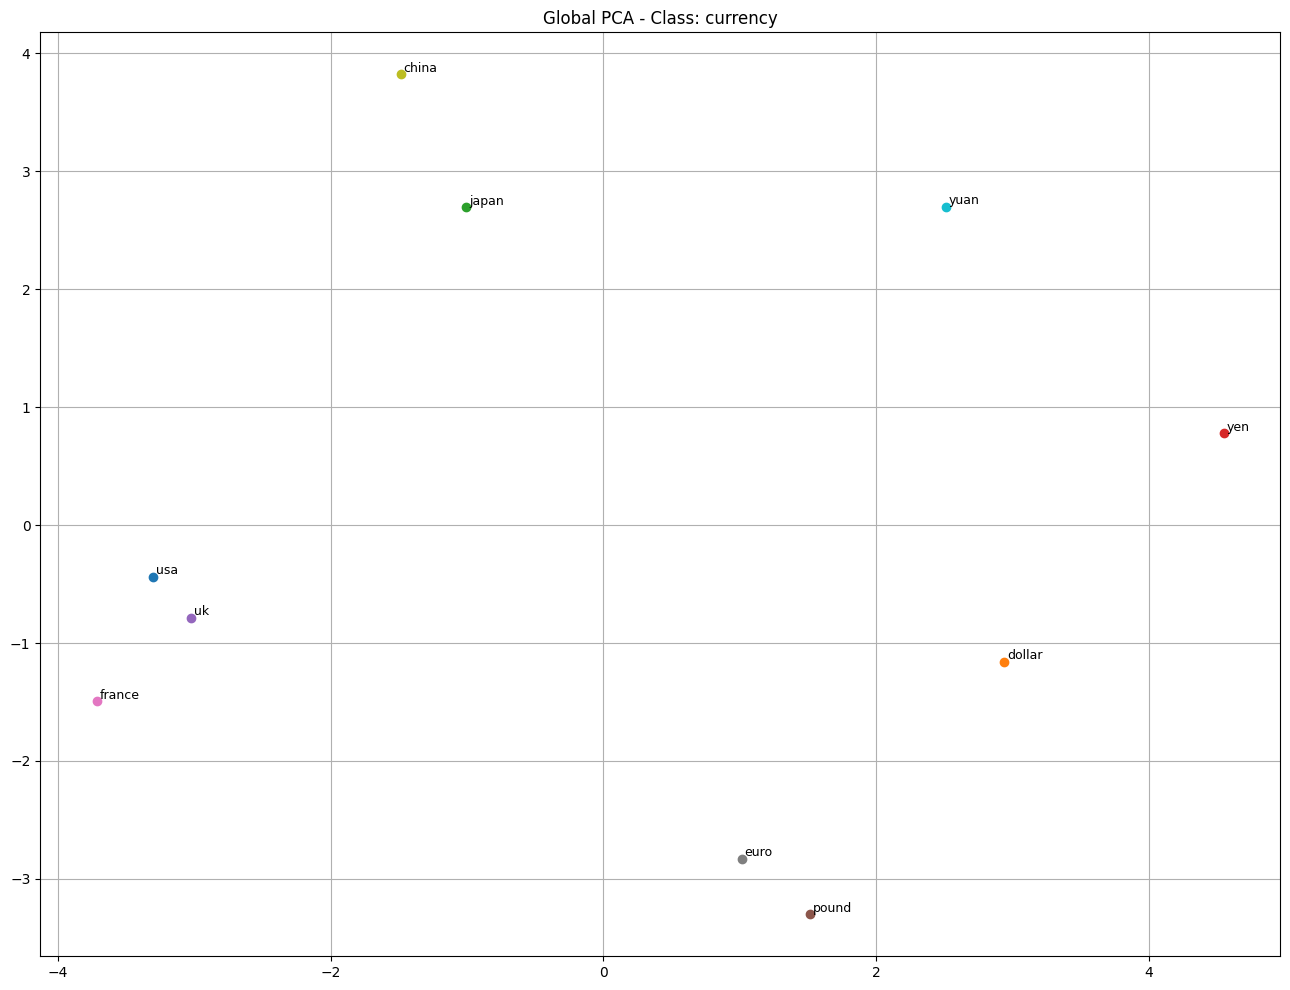

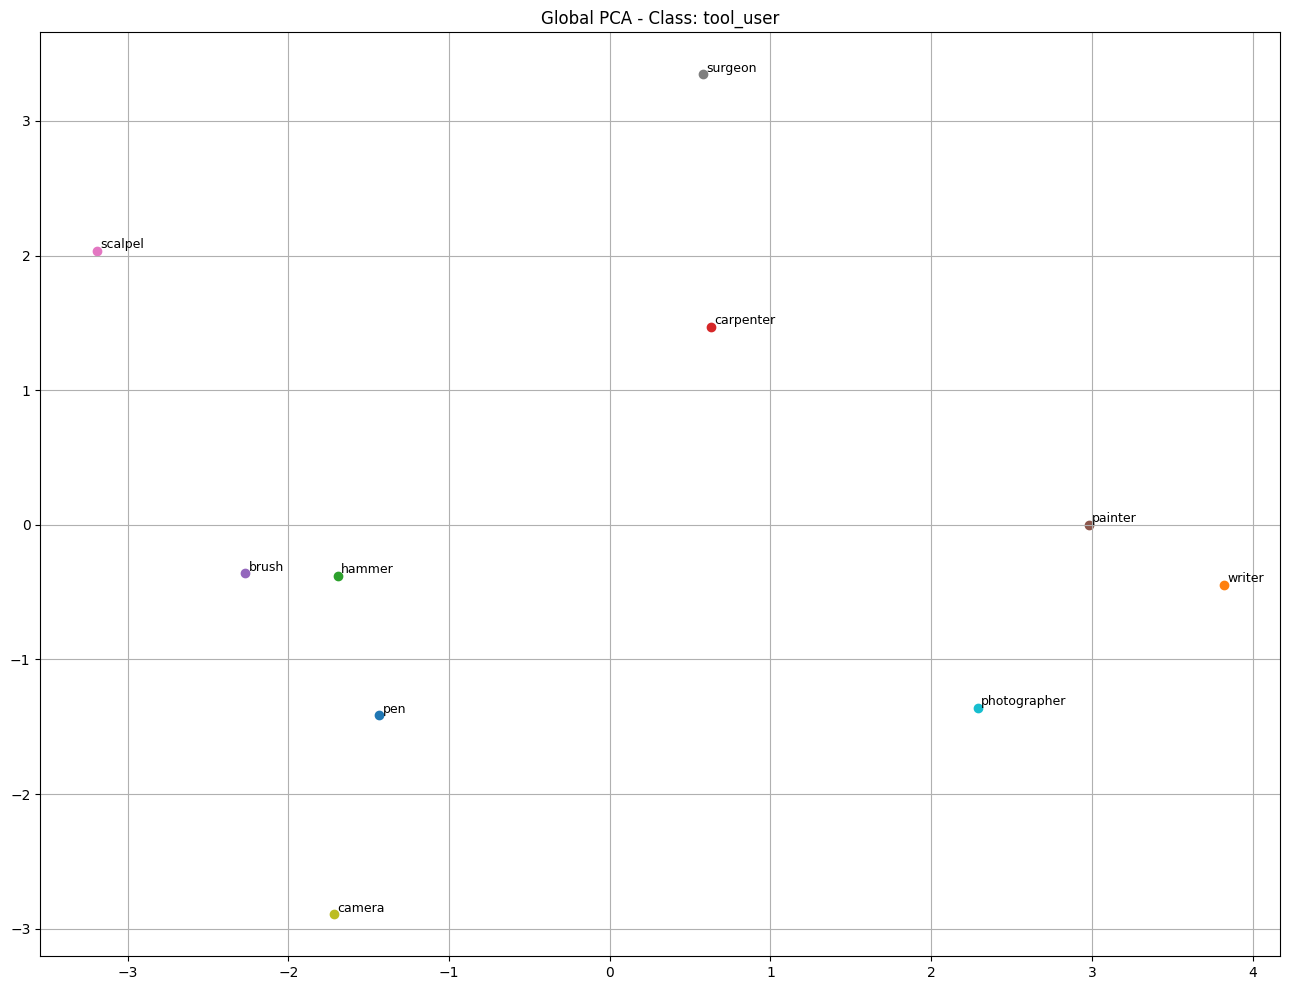

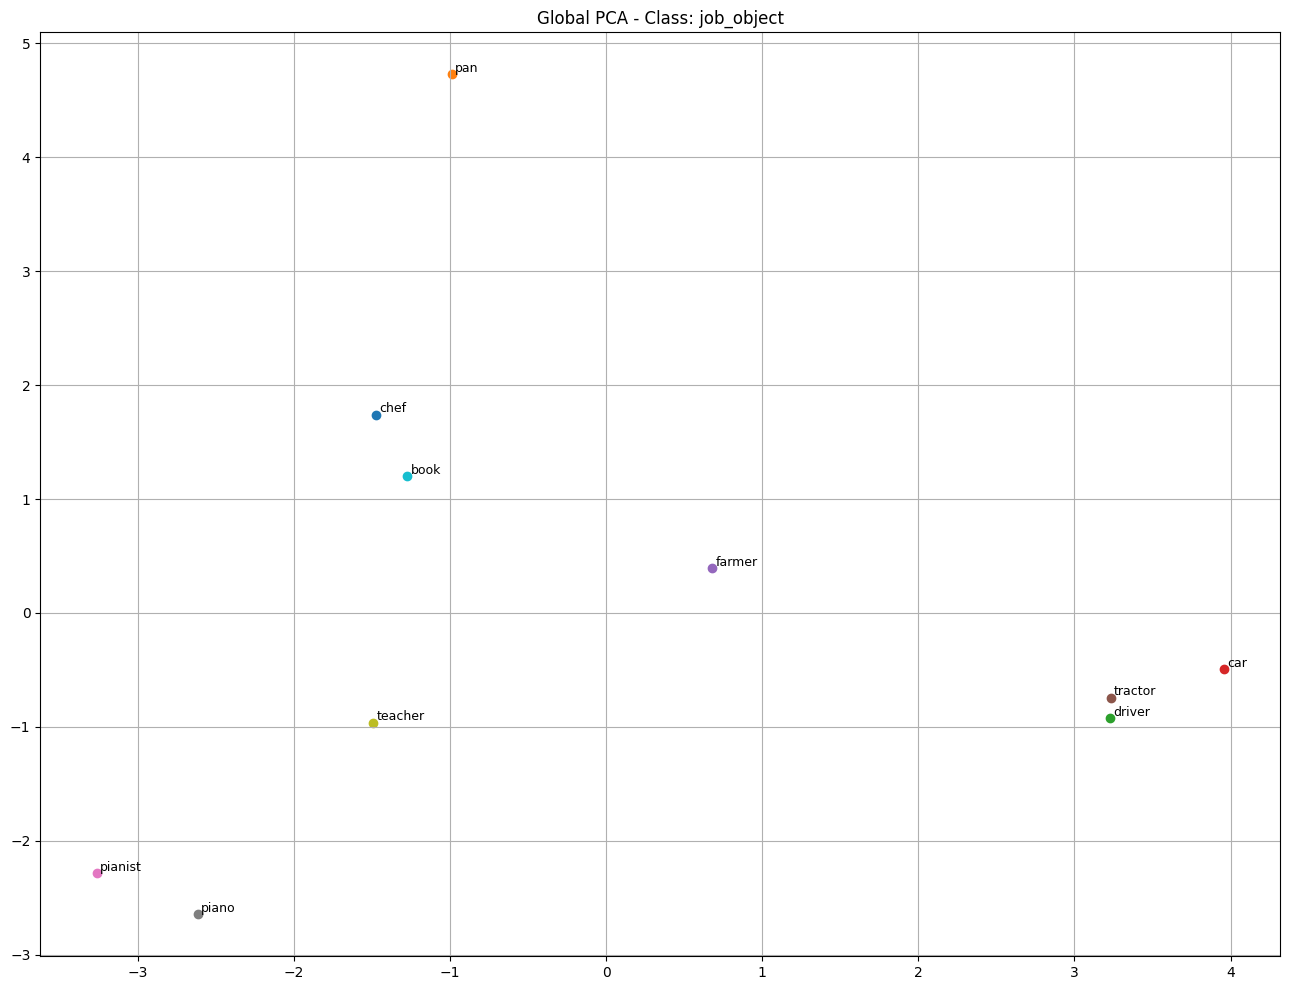

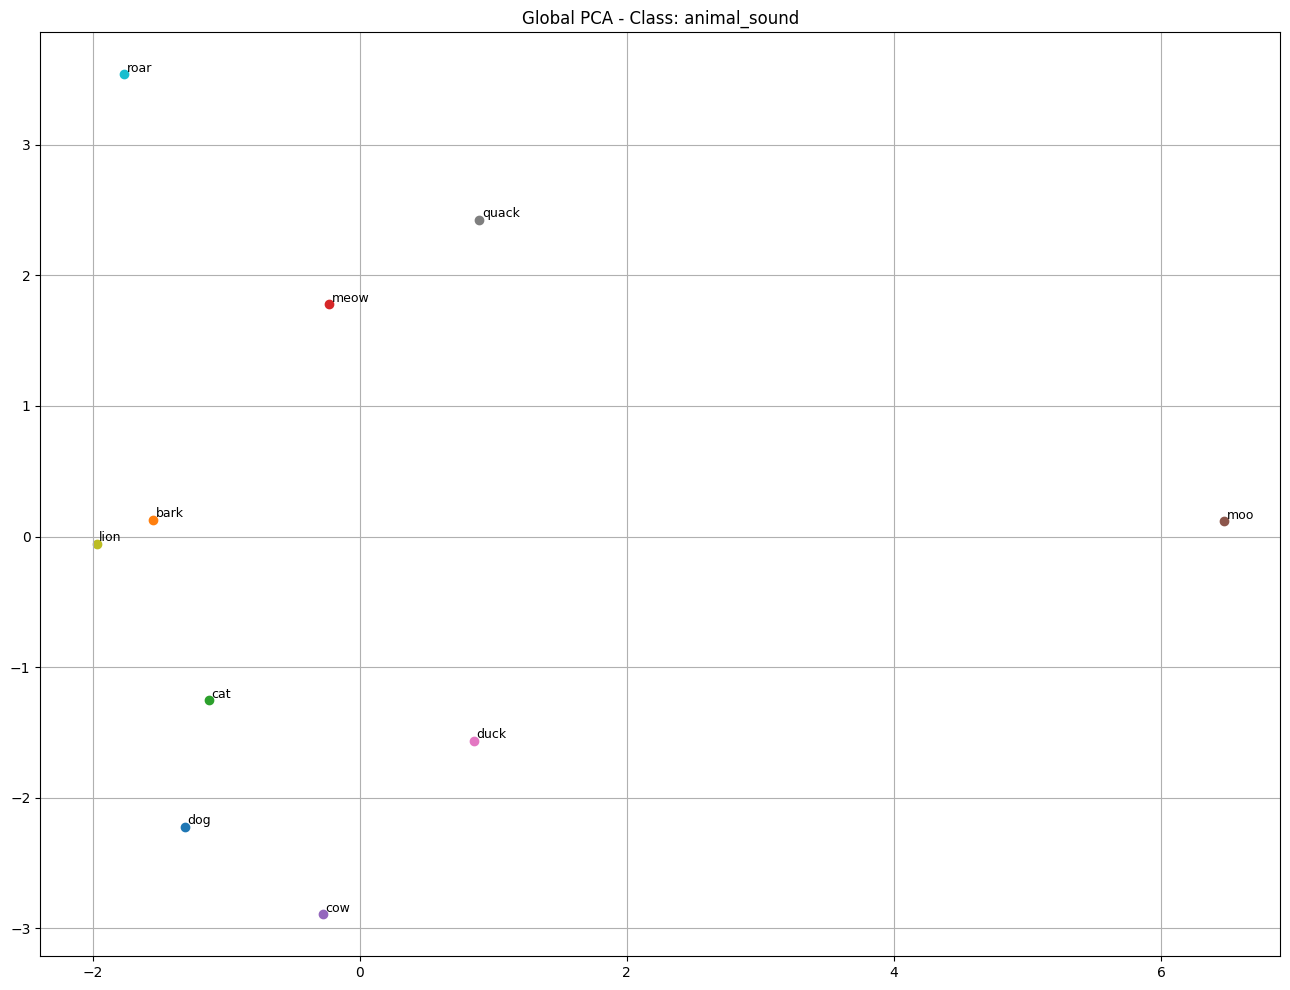

In [10]:
#Global PCA, but one class at a time &&& in a global space:
for class_name, pairs in semantic_classes.items():
    class_words = [w for pair in pairs for w in pair if w in word_vectors]
    plot_words_2d(class_words, word_vectors, f"Global PCA - Class: {class_name}")


**Comments**:
I'll comment of first few plots, rest can be seen analogusly..

First, **gender**: trajectories for every pair is simmilar. This mean that the differences between two words in each group give us simmilar results. Thac can couse things like the question we asked at the beggining: 'is king-man+queen=woman'? And yes, we'll get that result.

Second, **Verb tense past**: here 3 trajectories are simmilar (like in 'gender'), but other two differ signifficantly. This inconsistency can lead to conclusion that relationships between words in this group are not 1-1 (not consistent in the global wector space).

Thirdly (after skipping many analogous examples), **"Job Object**: trajectories are completly different. Pairs do not make any kind of consistent semantic shapes in this vector space.

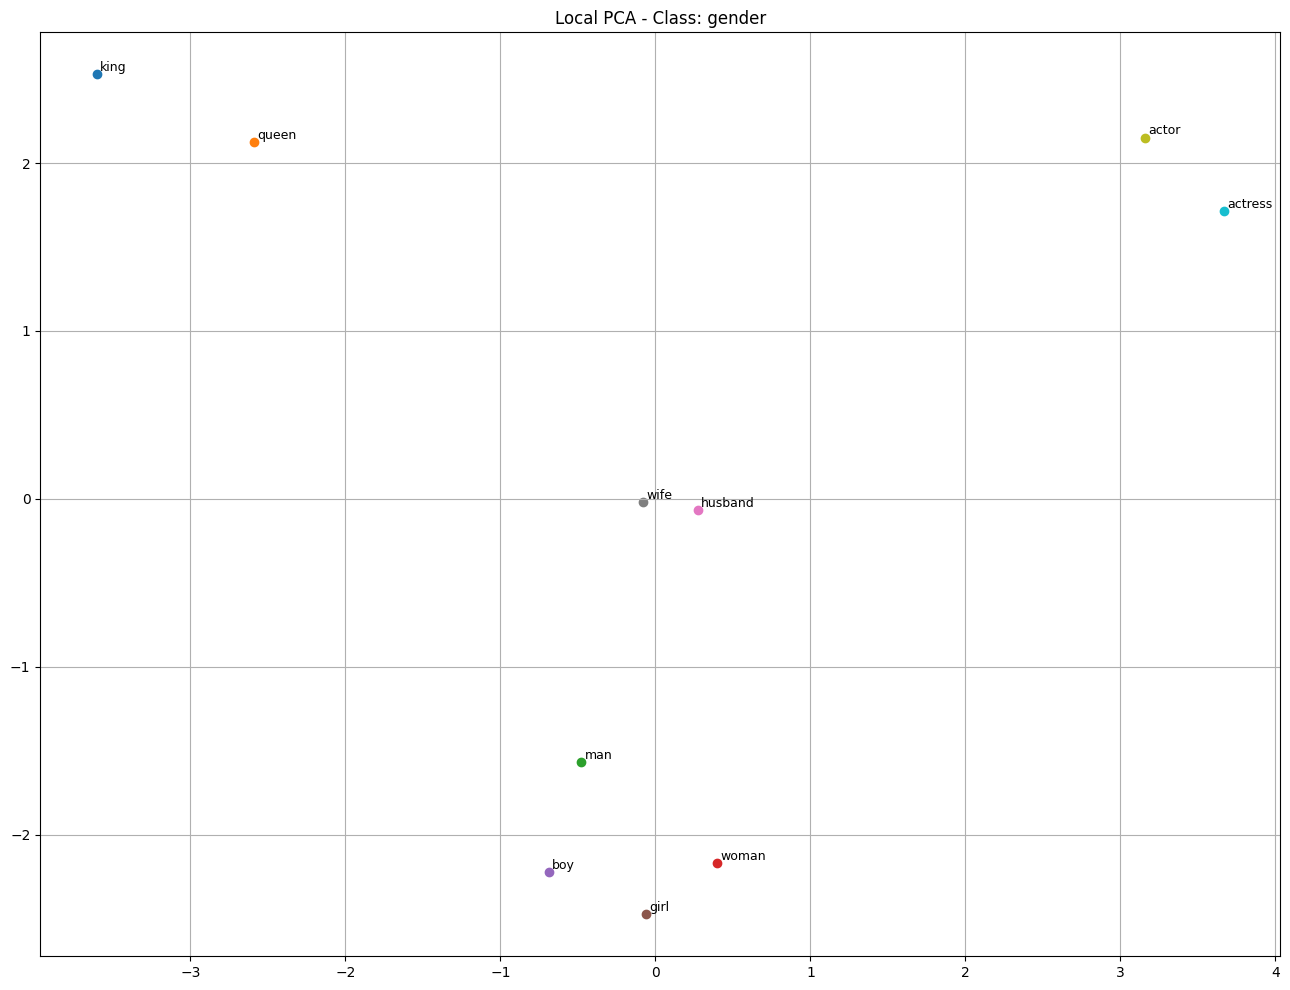

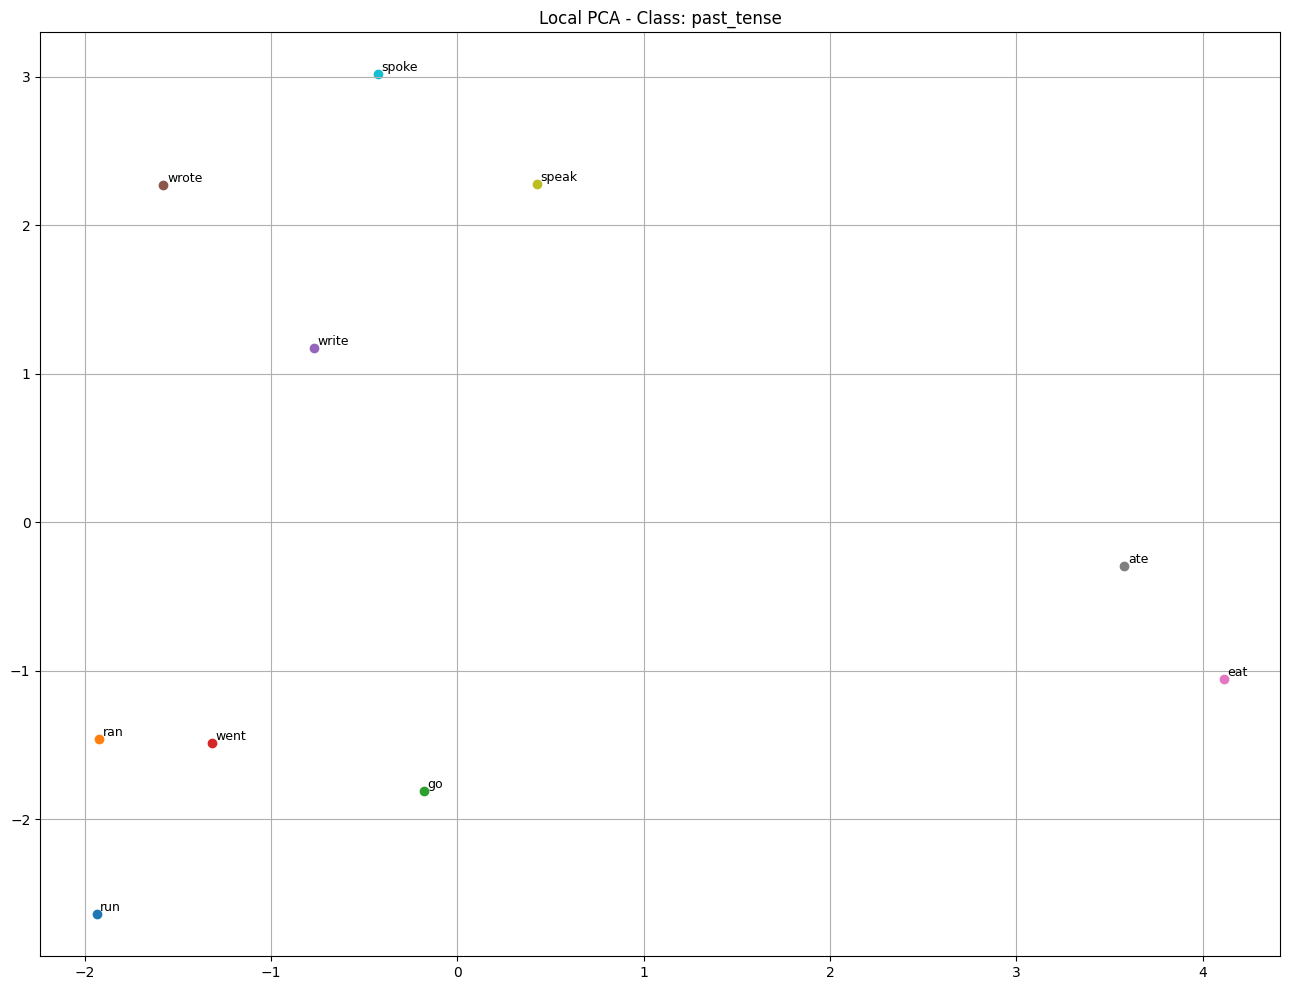

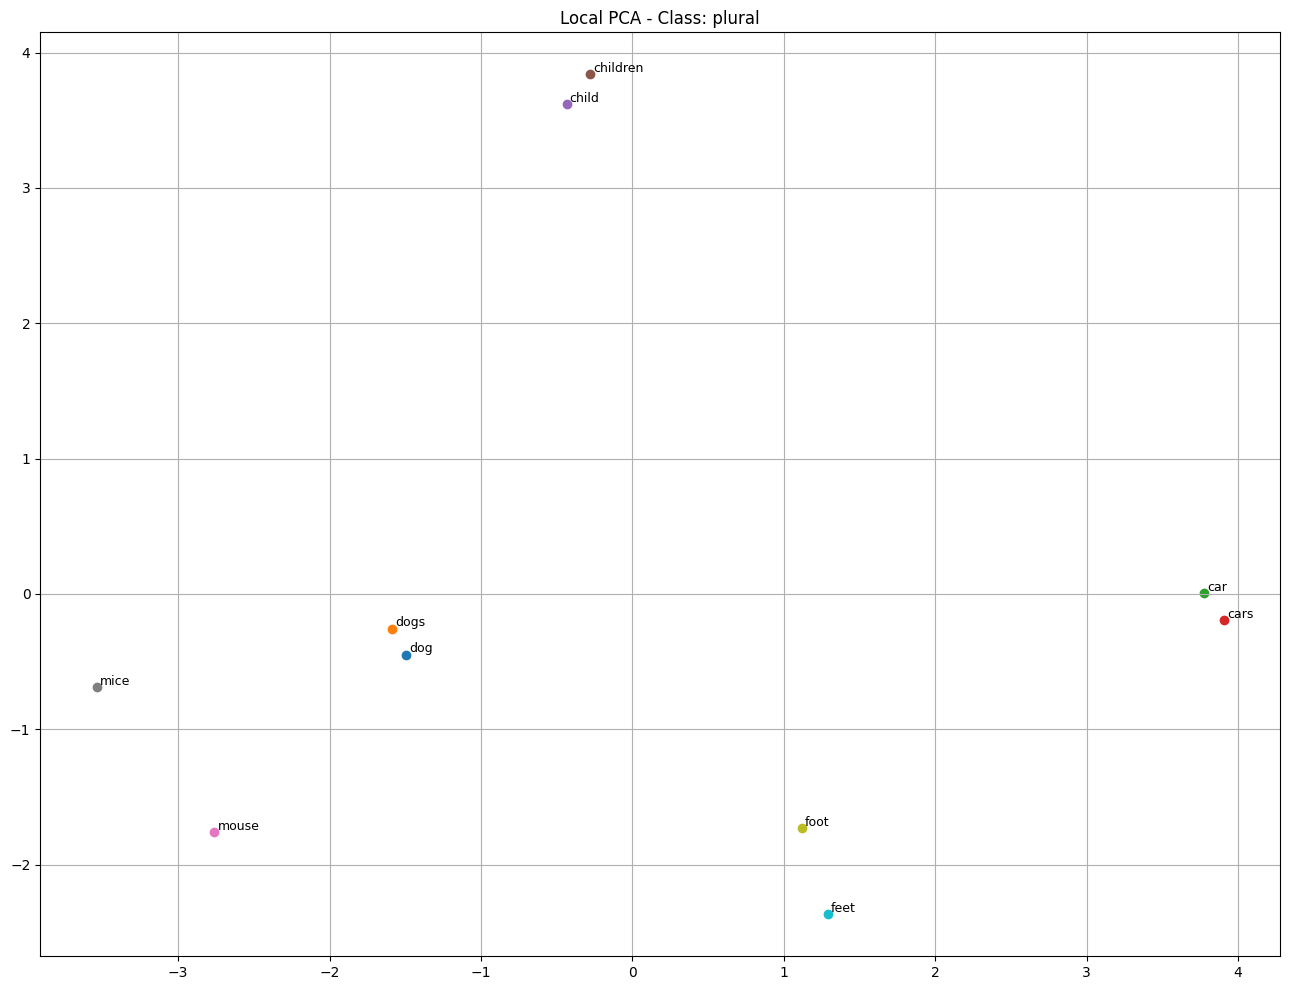

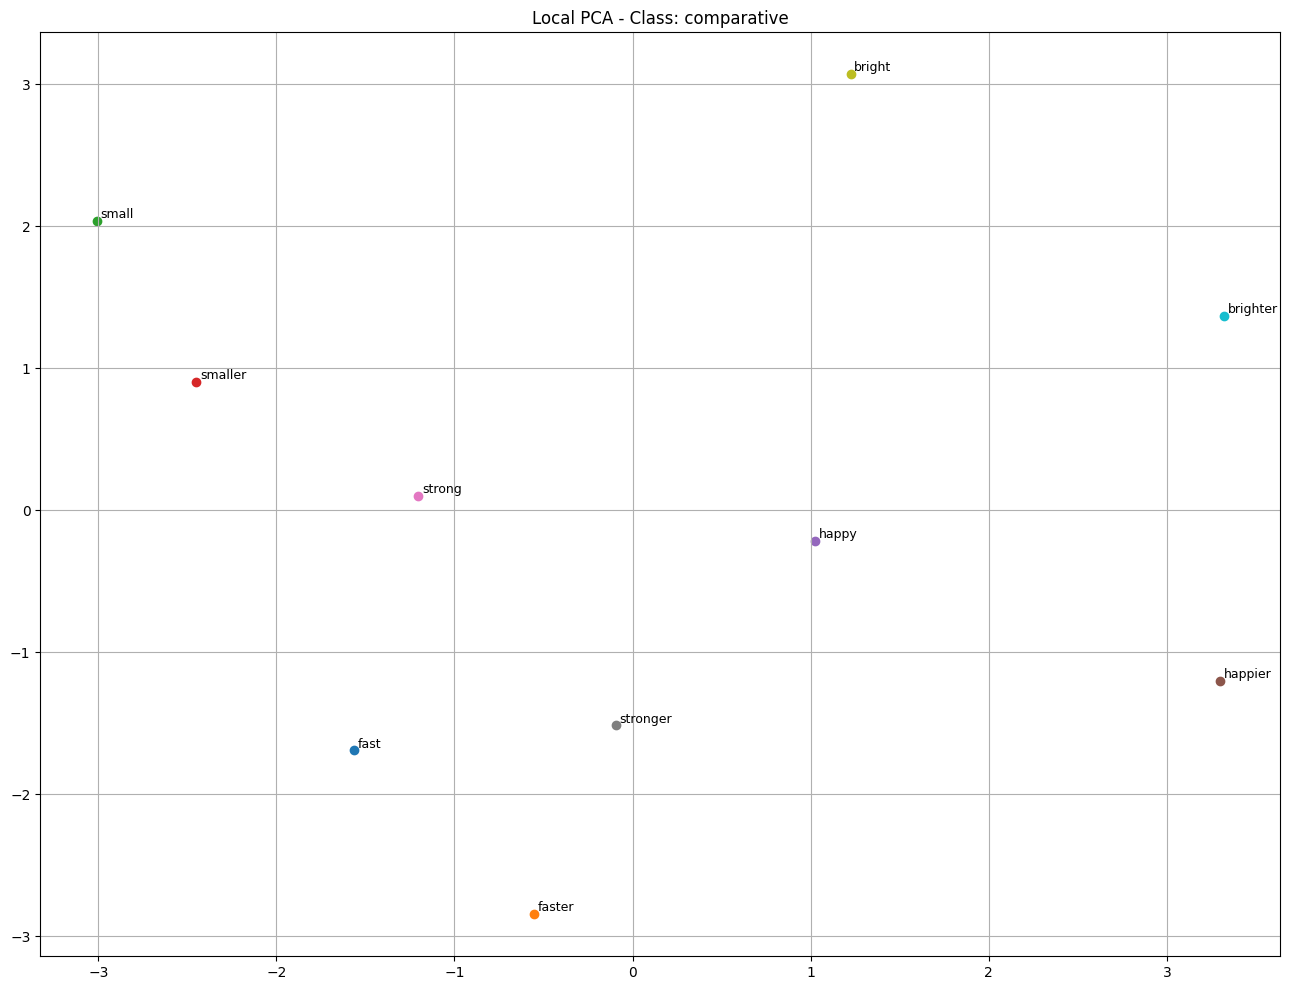

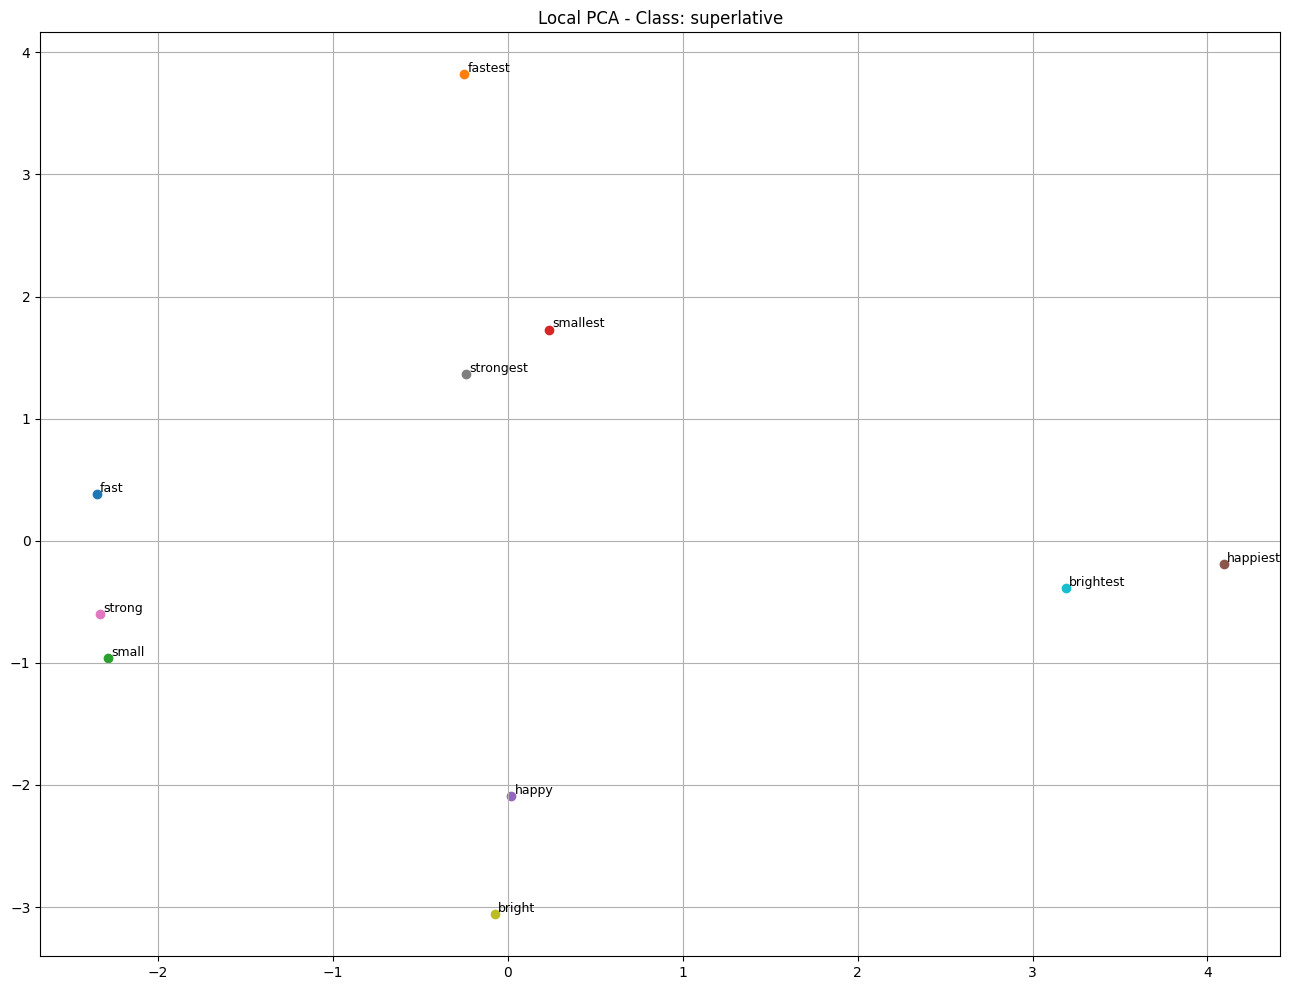

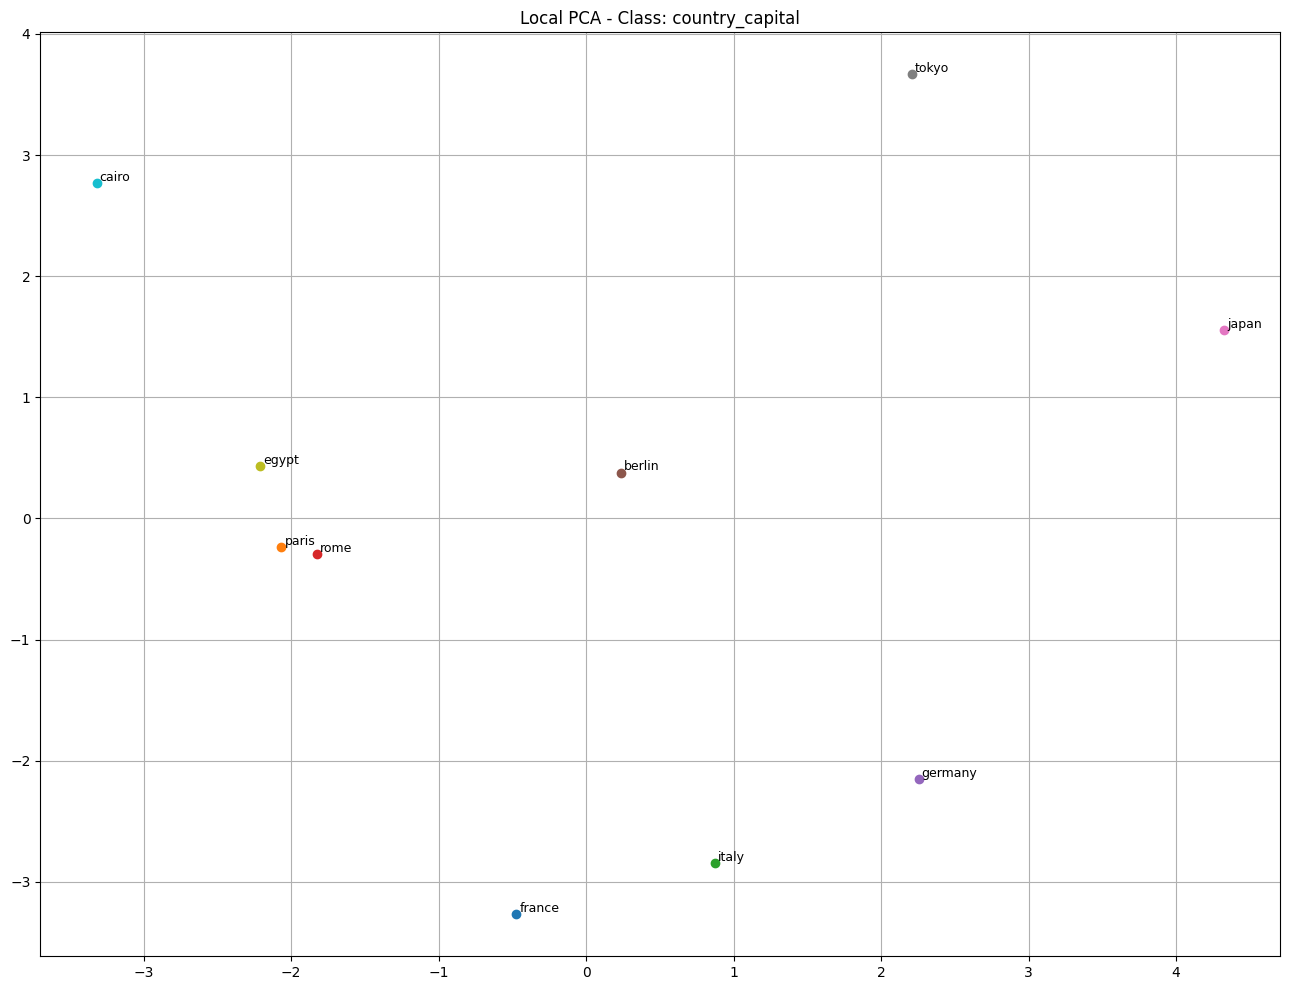

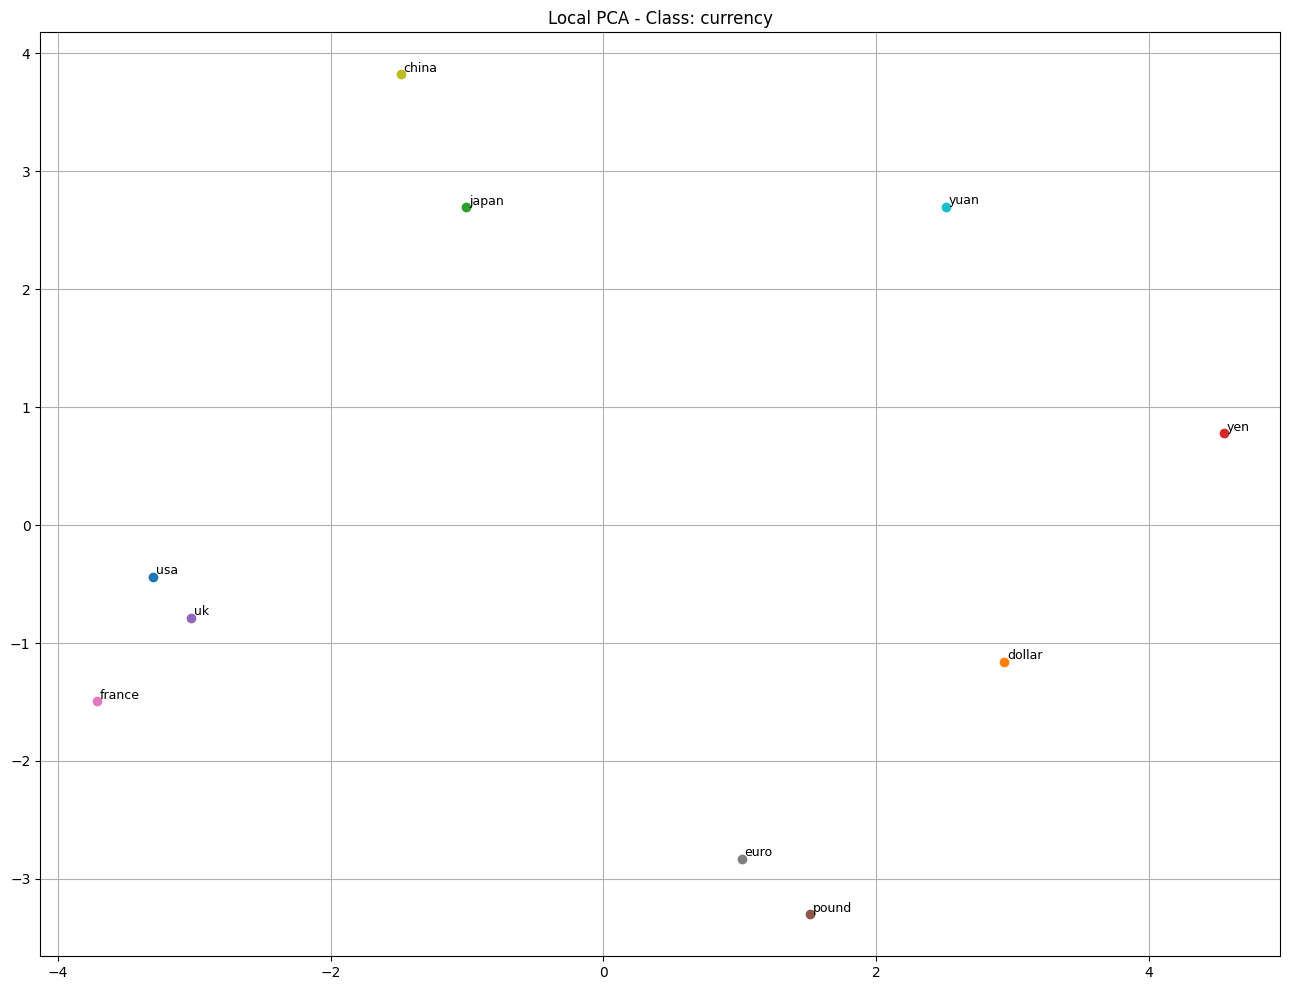

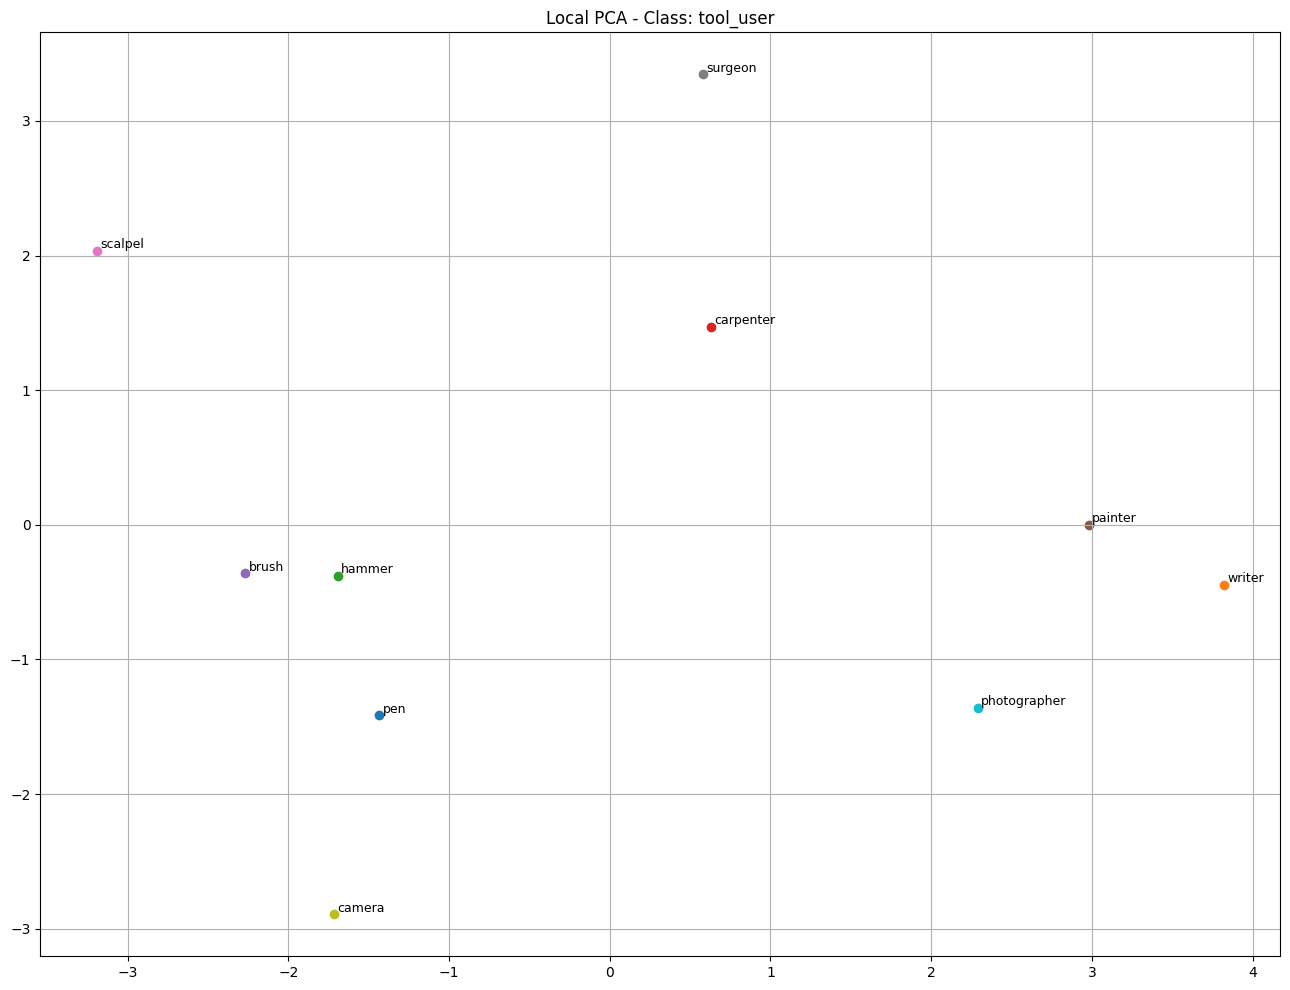

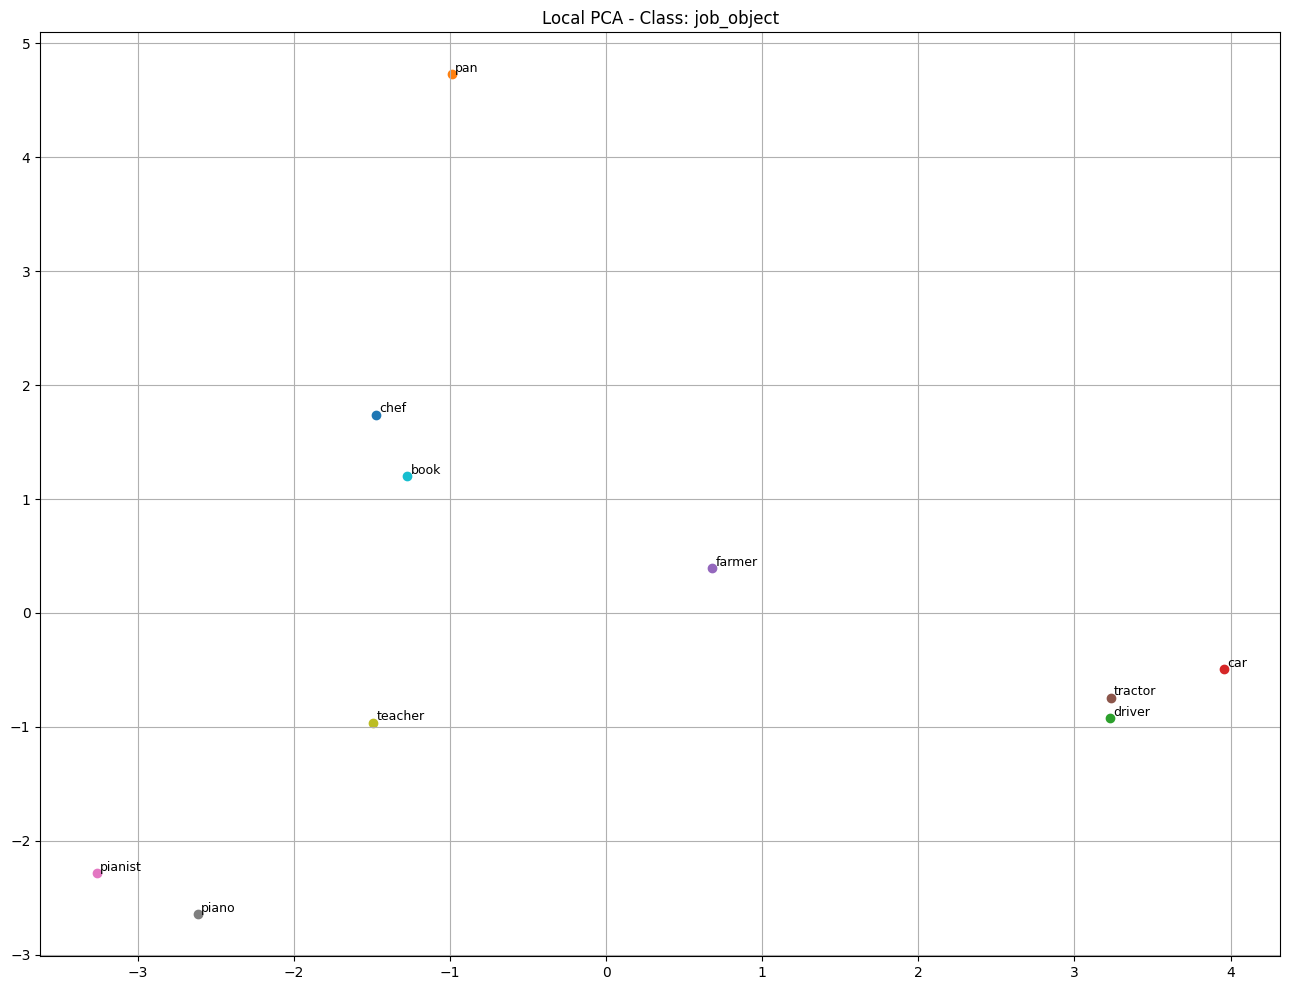

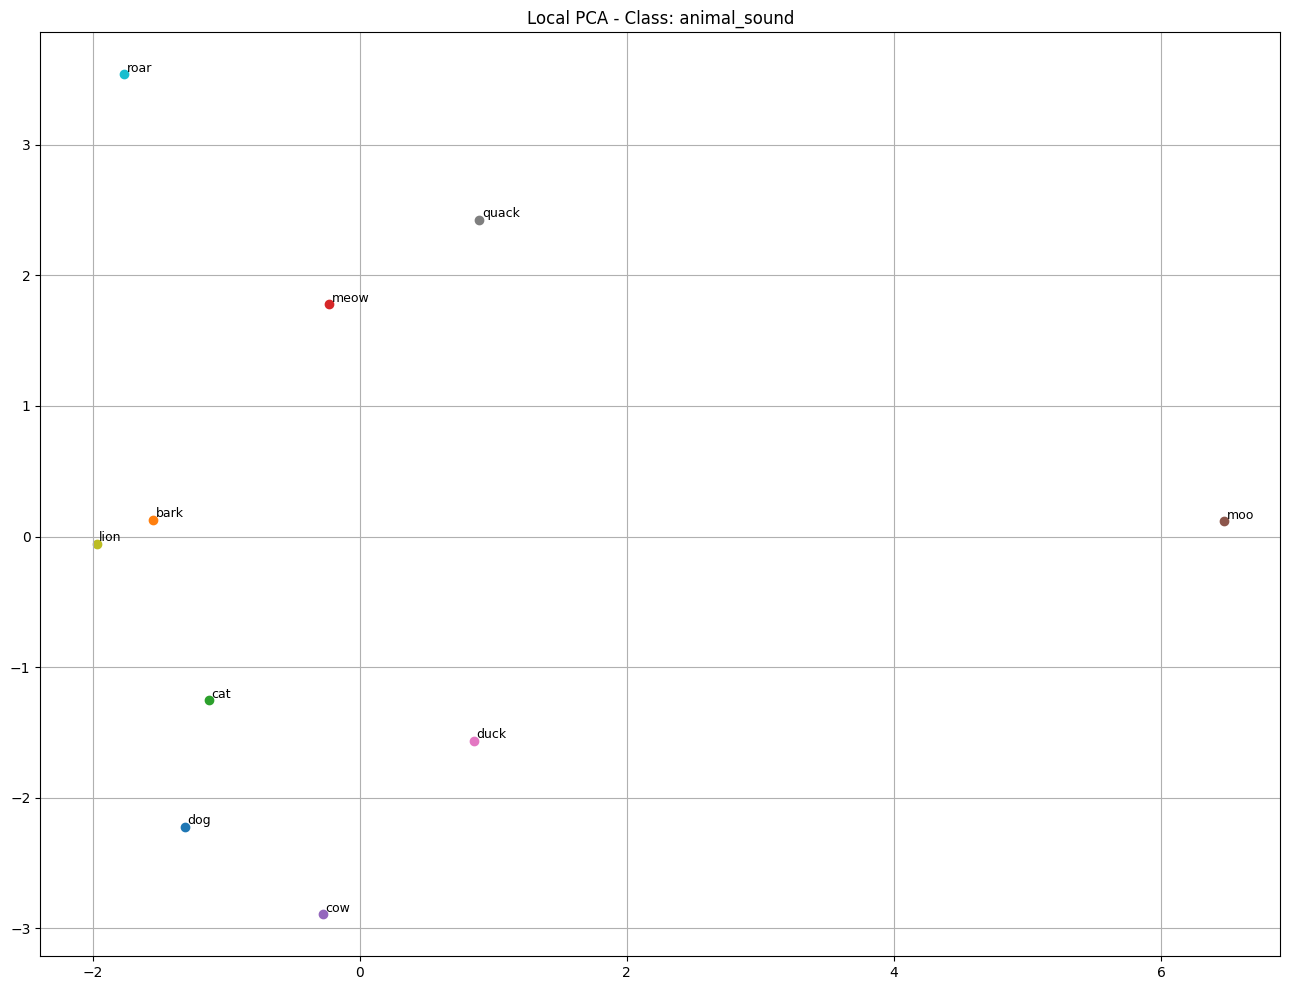

In [11]:
# Local PCA — each class separatelly, so PCA for 10 words in each class.
def plot_local_pca(class_name, pairs):
    class_words = [w for pair in pairs for w in pair if w in word_vectors]
    class_vectors = {word: word_vectors[word] for word in class_words}
    plot_words_2d(class_words, class_vectors, f"Local PCA - Class: {class_name}")

for class_name, pairs in semantic_classes.items():
    plot_local_pca(class_name, pairs)

We'll make comments to that later on...

-----------------------------
#Is really 'man' - 'king' + 'queen' = 'woman'?
-----------------------------

In [12]:
from sklearn.metrics.pairwise import cosine_similarity


In [13]:
def find_closest_words(vec, vectors_dict, topn=5):
    all_words = list(vectors_dict.keys())
    all_vecs = np.array([vectors_dict[w] for w in all_words])

    sims = cosine_similarity([vec], all_vecs)[0]
    sorted_indices = np.argsort(sims)[::-1]

    results = []
    for idx in sorted_indices[:topn]:
        results.append((all_words[idx], sims[idx]))
    return results

In [14]:
#Calculations for every class:
for class_name, pairs in semantic_classes.items():
    base_pair = pairs[0]  # (A, B)
    alt_pair = pairs[1]   # (C, D), let's take C

    A, B = base_pair
    C, _ = alt_pair

    if A in word_vectors and B in word_vectors and C in word_vectors:
        result_vec = word_vectors[B] - word_vectors[A] + word_vectors[C]
        top_matches = find_closest_words(result_vec, word_vectors)

        print(f"\n=== Class: {class_name} ===")
        print(f"Operation: {B} - {A} + {C}")
        for word, score in top_matches:
            print(f"{word:<15} similarity: {score:.4f}")
    else:
        print(f"\nSkipping class '{class_name}' due to missing word(s)")



=== Class: gender ===
Operation: queen - king + man
woman           similarity: 0.8040
man             similarity: 0.7791
girl            similarity: 0.7349
boy             similarity: 0.6447
wife            similarity: 0.6073

=== Class: past_tense ===
Operation: ran - run + go
go              similarity: 0.7532
went            similarity: 0.7360
ran             similarity: 0.6971
happy           similarity: 0.5492
write           similarity: 0.5175

=== Class: plural ===
Operation: dogs - dog + car
cars            similarity: 0.8827
car             similarity: 0.8765
driver          similarity: 0.6695
tractor         similarity: 0.5405
went            similarity: 0.4981

=== Class: comparative ===
Operation: faster - fast + small
smaller         similarity: 0.8129
small           similarity: 0.7961
faster          similarity: 0.6221
smallest        similarity: 0.5807
cars            similarity: 0.4932

=== Class: superlative ===
Operation: fastest - fast + small
smallest        simi

1. **Are the closest words from the arithmetic meaningful?**: Yes! Mostly. Like in gender, plural, comparative. In some it struggles a bit like in past_tense and in some it fails, like in animal_sound.
2. **What kinds of relationships are captured, and what are not?**: Most of them were pointed out above (in question 1).
3. **Are some classes better behaved than others?** Yes — the classes that follow a simpler and more consistent linguistic structure tend to behave better. These include categories with clear, regular patterns and fewer variations in usage. Good examples are sentence structure, gender, and plural forms. In contrast, more ambiguous or context-dependent categories such as animal sounds, tool–user, or job–object relationships tend to be less well-behaved.

-----------------------
Again comparison: global with local PCA, but in clearer form:
-----------------------

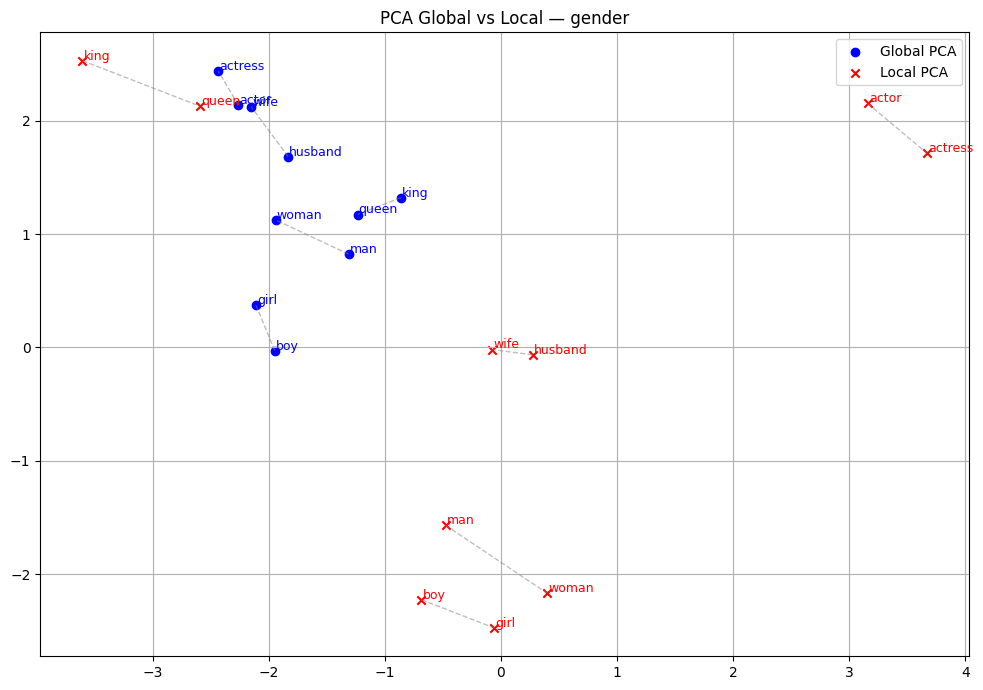

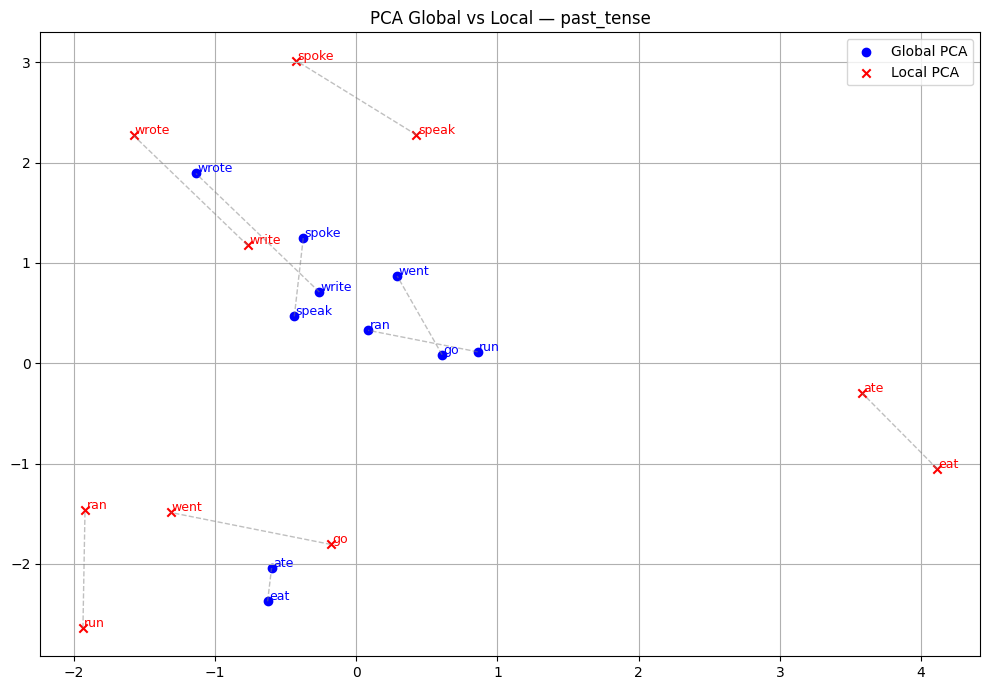

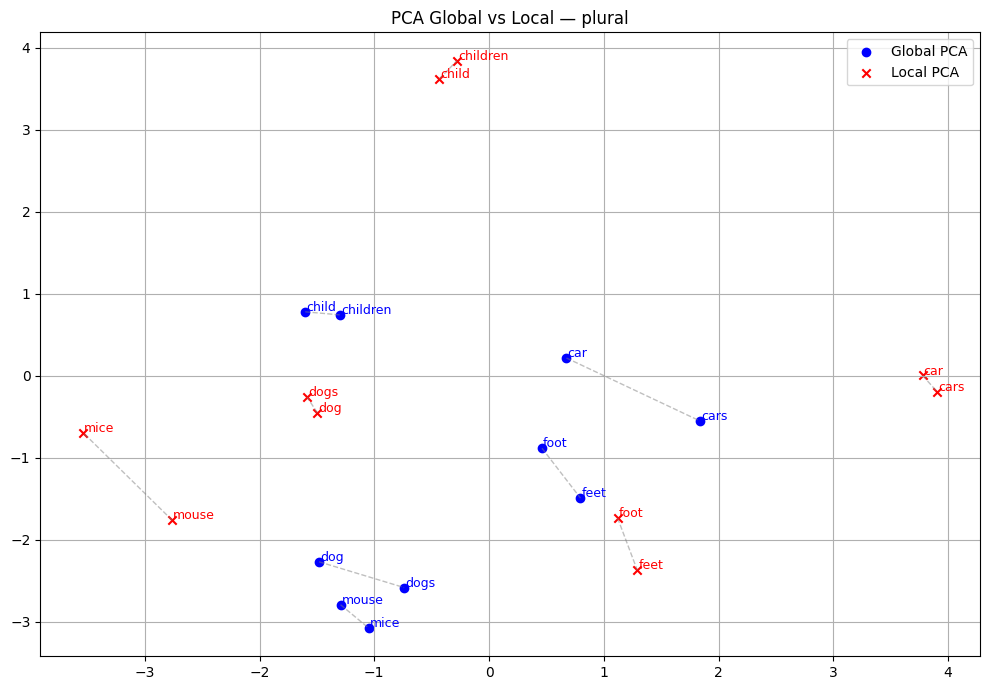

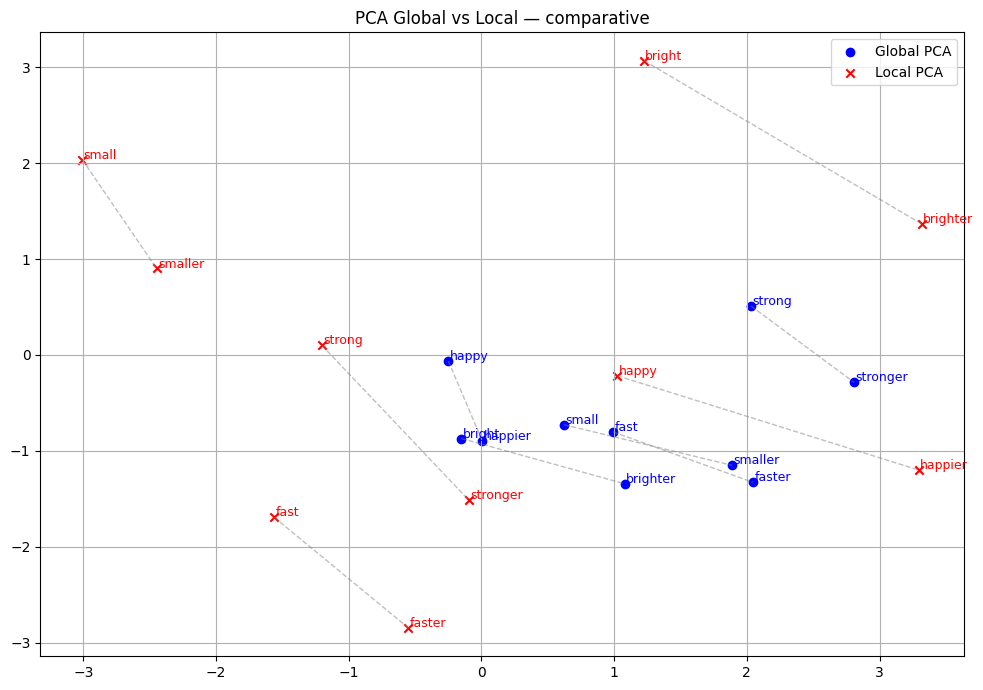

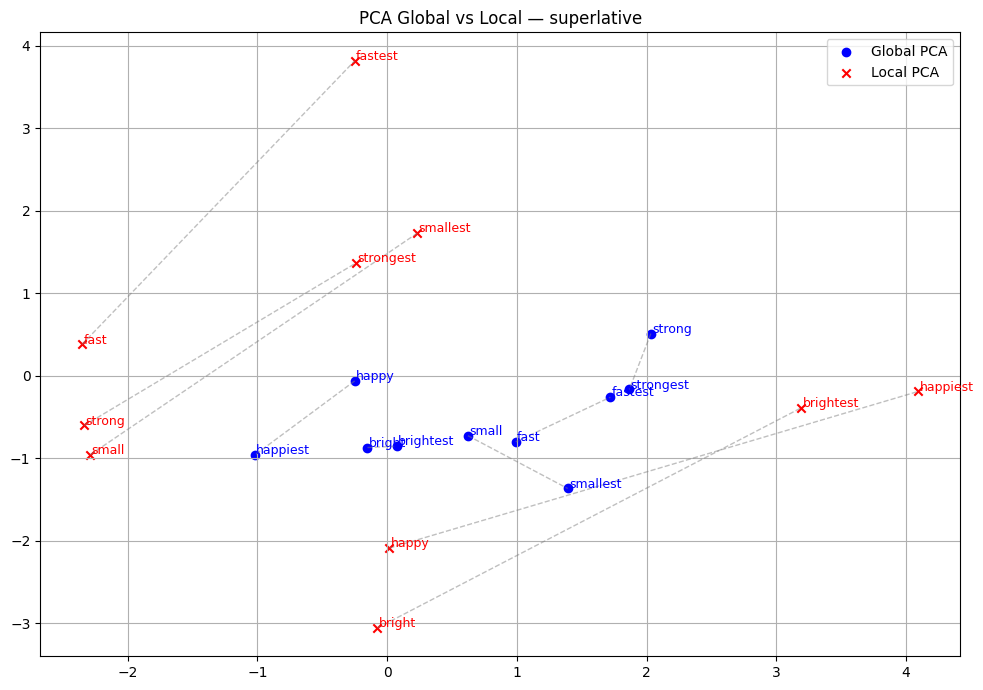

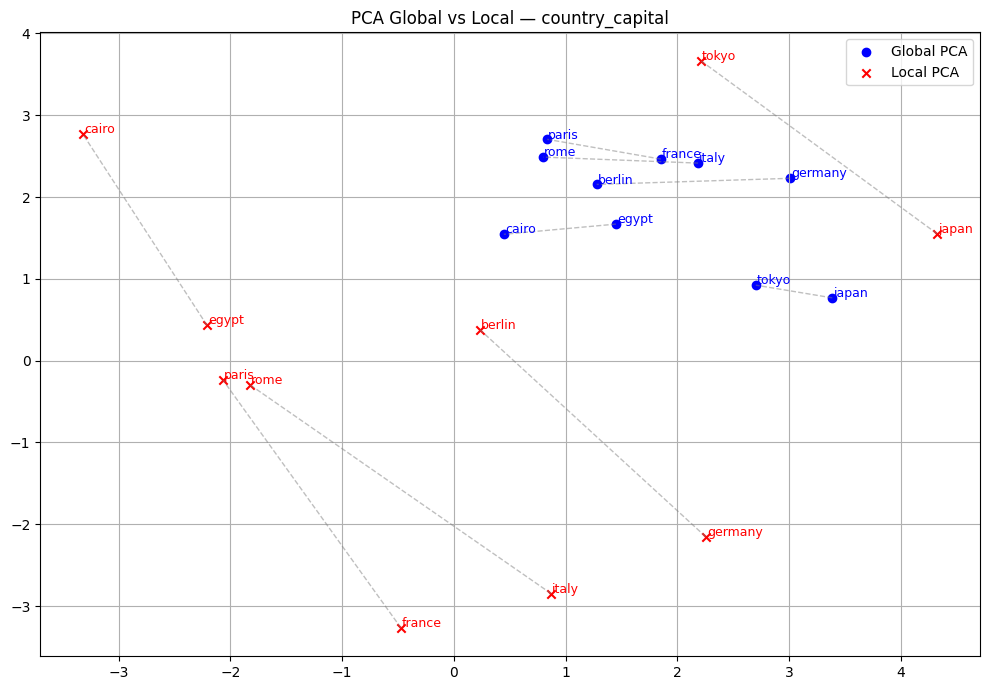

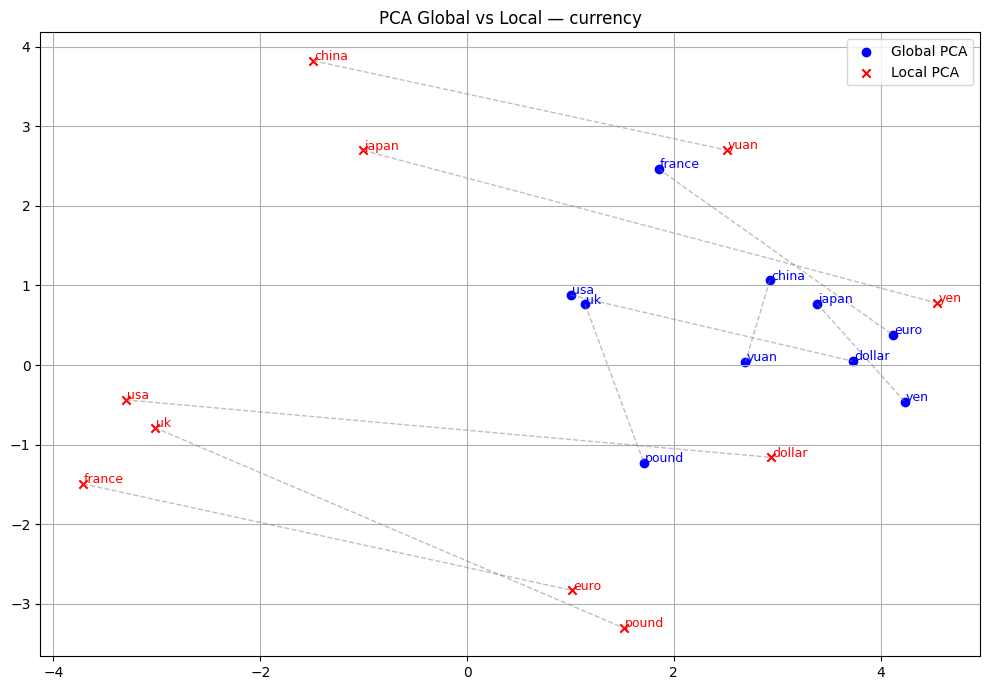

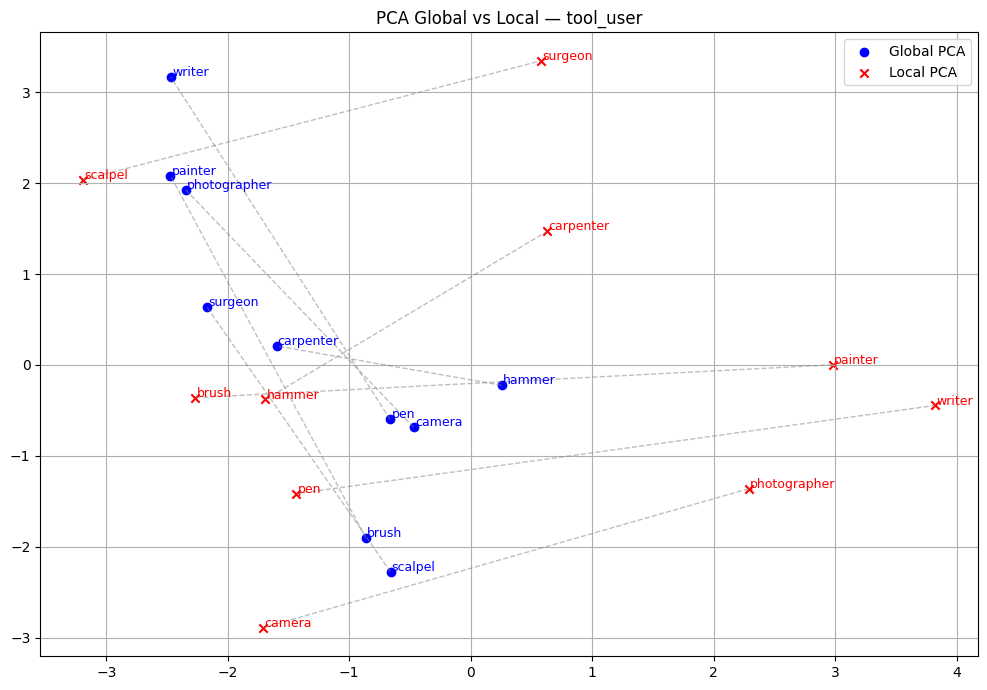

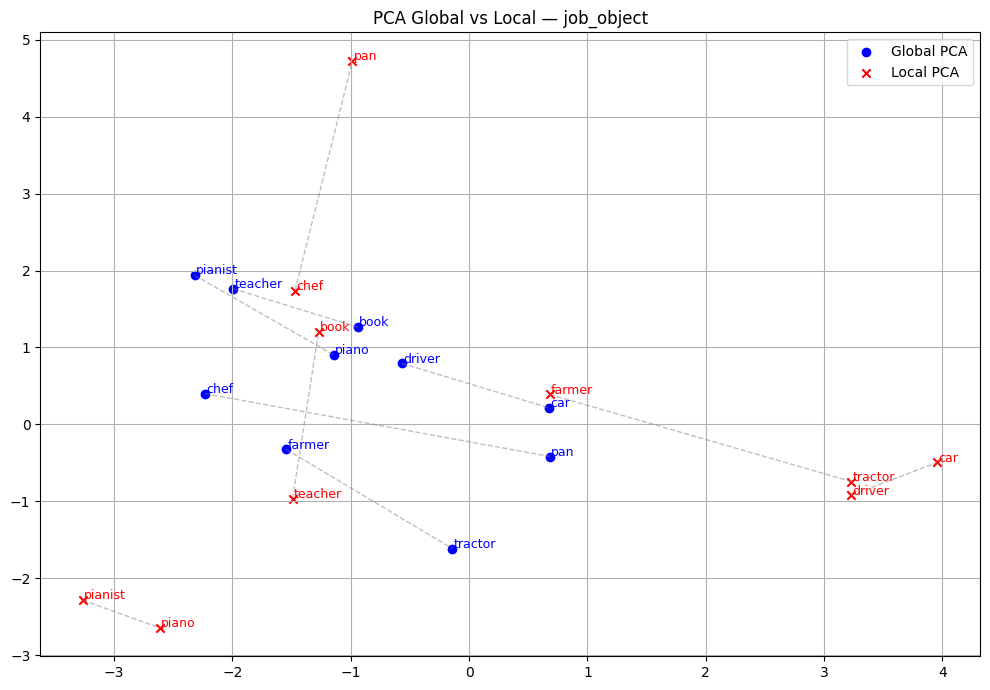

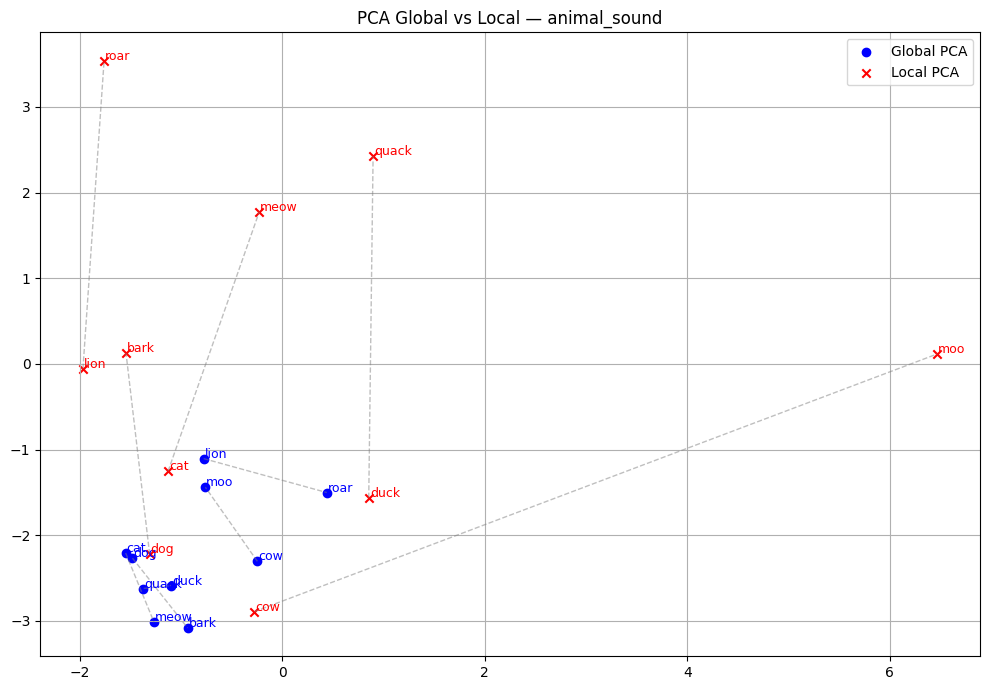

In [18]:
# Perform global PCA for all words with vectors
global_pca = PCA(n_components=2)
words = list(word_vectors.keys())
vectors = np.array([word_vectors[word] for word in words])
reduced_embeddings = global_pca.fit_transform(vectors)

# Create a dictionary: word -> global PCA coordinates
global_pca_dict = {word: reduced_embeddings[i] for i, word in enumerate(words)}

# Plot overlay charts for each class (global vs local PCA)
for class_name, pairs in semantic_classes.items():
    # Flatten pairs into list of words (filtering only those present in word_vectors)
    words_in_class = [word for pair in pairs for word in pair if word in word_vectors]

    # Skip class if any word is missing (to avoid KeyError)
    if not all(word in global_pca_dict for word in words_in_class):
        print(f"Skipping {class_name}: missing words in global PCA")
        continue

    # Global coordinates
    global_coords = np.array([global_pca_dict[word] for word in words_in_class])

    # Local coordinates
    local_vectors = np.array([word_vectors[word] for word in words_in_class])
    pca_local = PCA(n_components=2)
    local_coords = pca_local.fit_transform(local_vectors)

    # Mapping word to its coordinates
    global_word_coords = {word: global_pca_dict[word] for word in words_in_class}
    local_word_coords = {word: local_coords[i] for i, word in enumerate(words_in_class)}

    # Plotting
    plt.figure(figsize=(10, 7))
    for i, word in enumerate(words_in_class):
        # Global: blue circles
        plt.scatter(global_coords[i, 0], global_coords[i, 1], color='blue', marker='o', label='Global PCA' if i == 0 else "")
        plt.text(global_coords[i, 0] + 0.01, global_coords[i, 1] + 0.01, word, fontsize=9, color='blue')

        # Local: red crosses
        plt.scatter(local_coords[i, 0], local_coords[i, 1], color='red', marker='x', label='Local PCA' if i == 0 else "")
        plt.text(local_coords[i, 0] + 0.01, local_coords[i, 1] + 0.01, word, fontsize=9, color='red')

    # Draw lines between corresponding words in each pair (global)
    for w1, w2 in pairs:
        if w1 in global_word_coords and w2 in global_word_coords:
            x1, y1 = global_word_coords[w1]
            x2, y2 = global_word_coords[w2]
            plt.plot([x1, x2], [y1, y2], color='gray', linestyle='dashed', linewidth=1, alpha=0.5)

    # Draw lines between corresponding words in each pair (local)
    for w1, w2 in pairs:
        if w1 in local_word_coords and w2 in local_word_coords:
            x1, y1 = local_word_coords[w1]
            x2, y2 = local_word_coords[w2]
            plt.plot([x1, x2], [y1, y2], color='gray', linestyle='dashed', linewidth=1, alpha=0.5)

    plt.title(f"PCA Global vs Local — {class_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# **Last Comments**:
Now we start to see anything. Global PCA preserves strong relations, like 'Comparative' or 'job_object', but local PCA can be better at, for instance, 'past_tense', where it better captures the differences that may be to small to notice in global PCA.

**Does PCA capture semantic differences?**
The anwser is yes and no. We cannot say that it is perfect at capturing those differences. It does a good job at some relations and a bad job at others. And in some none of them does a decent job, like past_tense as I observe.

____________